# Hateful Memes Challenge

The Hateful Meme Challenge aims to spur innovation in the detection of hateful memes, a task highly dependent on human subtleties rather than facts. 

1. **Define the Problem:** Perhaps the most important section, we will lay out what exactly needs to be classified as hateful and not hateful

2. **Gather the data:** A dataset of 10K memes is already provided by FB. We might revisit this step at the end, however, as external data is allowed in the challenge rules and may help.

3. **Prepare data for consumption:** As in 2., the data has been prepared according to Chapter 2 of the Challenge Paper (Source #1). We will still need to transform it into actionable formats. On the forums, however, is has been noted & confirmed that several images might have been misclassified. We could account for that at the end.

4. **Perform exploratory analysis:** In this step we will visualize several images and try to group them, to gain a better understanding of the data at hand.

5. **Model Data:** This is where the heavylifting will have to be done. As we face a multimodal problem, we will start with basic models for each mode and later work on fusion mechanisms. Using the dev set we will optimize the model.

6. **Validate & Implement:** In this step we determine whether our model underfit, overfit or generalizes well in respect to the dataset. After some iteration between 5 & 6 we submit the model.

7. **Optimize & Strategize:** This is where we will revisit some ideas in the early steps and think about new unorthodox solutions. 

# 1. Define the Problem

## 1.1 The Libraries

The following code-cell imports all the necessary libraries. Having them in one place eases migration to script coding.

In [2]:
# Data & Modelling related
import string

import os

import re

from collections import Counter
from collections import OrderedDict 

import torch 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, Dataset
from torch import nn
import torch.optim as optim

import torchvision
from torchvision import models, transforms

import pandas as pd
import numpy as np

import sklearn
from sklearn import metrics

import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

from PIL import Image
import imagehash

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Other
import time
import datetime
import random


# MMF - Multimodal framework by FB Research (Source #3)
# !pip install --upgrade --pre mmf
# import mmf

## 1.2 The Problem

The problem is defined as follows:

"Your goal is to predict whether a meme is hateful or non-hateful. This is a binary classification problem with multimodal input data consisting of the the meme image itself (the image mode) and a string representing the text in the meme image (the text mode).

Given a meme id, meme image file, and a string representing the text in the meme image, your trained model should output the probability that the meme is hateful."

Whether a meme is to be classified as hateful or not is further **defined as:**

"A direct or indirect attack on people based on characteristics, including ethnicity, race, nationality, immigration status, religion, caste, sex, gender identity, sexual orientation, and disability or disease. We define attack as violent or dehumanizing (comparing people to non-human things, e.g. animals) speech, statements of inferiority, and calls for exclusion or segregation. Mocking hate crime is also considered hate speech."

**Exceptions:**

"attacking individuals/famous people is allowed if the attack is not based on any of the protected characteristics listed in the definition. Attacking groups perpetrating hate (e.g. terrorist groups) is also not considered hate. This means that hate speech detection also involves possibly subtle world knowledge."


**Summary:**


We shall build a classifier to detect memes attacking people except for:
- celebrities (except for certain characteristics)
- groups perpetrating hate themselves

## 1.3 The Evaluation

The metric used for evaluation will be the AUC ROC – Area Under the Curve of the Receiver Operating Characteristic. We will submit the proba's & labels of each class in the format of float64 & int64, respectively. The proba's are used for the AUC ROC Calculation (What matters) & the labels to calculate Accuracy. This means we aim to maximize:

- **Sensitivity (True Positives)** – Hateful Memes correctly classified as hateful
- **Specificity (True Negatives)** – Non-hateful Memes correctly classified as non-hateful

By moving the threshold we are able to maximize one of those to 100%, which is why we plot all possbile thresholds and take the AUC as our final metric. We use Sensitivity as y-axis and 1-Specificity (=False Positives) as x-axis.

Important to know when analyzing different AUC_ROC & Accuracy values, is that AUC_ROC shows you how good your algorithm is at ranking the different items by comparing all possible thresholds. Accuracy only shows you one such threshold, at 0.5 & is hence inferior in content.

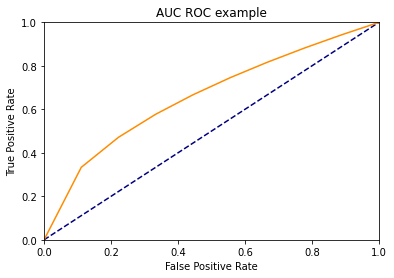

In [3]:
plt.figure()

# Random expected curve (Area = 0.5) - You should not be worse than this for binary classification
plt.plot([0,1], [0,1], color='navy', ls='--')

# Example curve - In reality it will look more blocky
x = np.linspace(0, 1, 10)
y = np.sqrt(x)
plt.plot(x, y, color='darkorange')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC ROC example')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])



plt.show()

# 2. Gather the data

Train, Validation & Test data is all given in the input files. We may come back to this step for external data.

# 3. Prepare data for consumption

In this step we will extract the data and go about cleaning our data according to the 4 C's.

## 3.1 Meet & Greet Data

Let's start by getting the data. The splits are already provided for us as follows: 
**85% Train, 5% Dev, 10% Test** (Source 1)

In [4]:
base_path = '/kaggle/input/fbmdatanopw/data/'
password = 'KexZs4tn8hujn1nK'

# Lines = True as each line is a json object of its own
train_df = pd.read_json(base_path + 'train.jsonl', lines=True)
dev_df = pd.read_json(base_path + 'dev.jsonl', lines=True)
test_df = pd.read_json(base_path + 'test.jsonl', lines=True)

# Previewing data
print(train_df.info())
print('-' * 50)
print(dev_df.info())
print('-' * 50)
print(test_df.info())
print('-' * 50)

# Sampling data
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      8500 non-null   int64 
 1   img     8500 non-null   object
 2   label   8500 non-null   int64 
 3   text    8500 non-null   object
dtypes: int64(2), object(2)
memory usage: 265.8+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      500 non-null    int64 
 1   img     500 non-null    object
 2   label   500 non-null    int64 
 3   text    500 non-null    object
dtypes: int64(2), object(2)
memory usage: 15.8+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
--

id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolate chip cookies, even h...

# PLEASE NOTE THAT THE BELOW CONTENT MAY BE SENSITIVE # 
# 请注意，以下内容可能具有侮辱性 #

0    its their character not their color that matters
Name: text, dtype: object
1    don't be afraid to love again everyone is not like your ex
Name: text, dtype: object
2    putting bows on your pet
Name: text, dtype: object
3    i love everything and everybody! except for squirrels i hate squirrels
Name: text, dtype: object
4    everybody loves chocolate chip cookies, even hitler
Name: text, dtype: object
5    go sports! do the thing! win the points!
Name: text, dtype: object
6    fine you're right. now can we fucking drop it?
Name: text, dtype: object
7    tattoos are bad for your health i know 5 million people that had tattoos and they all died
Name: text, dtype: object
8    how long can i run? till the chain tightens
Name: text, dtype: object

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/opt/conda/lib/python3.7/site-packages/pandas/_config/config.py:622: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


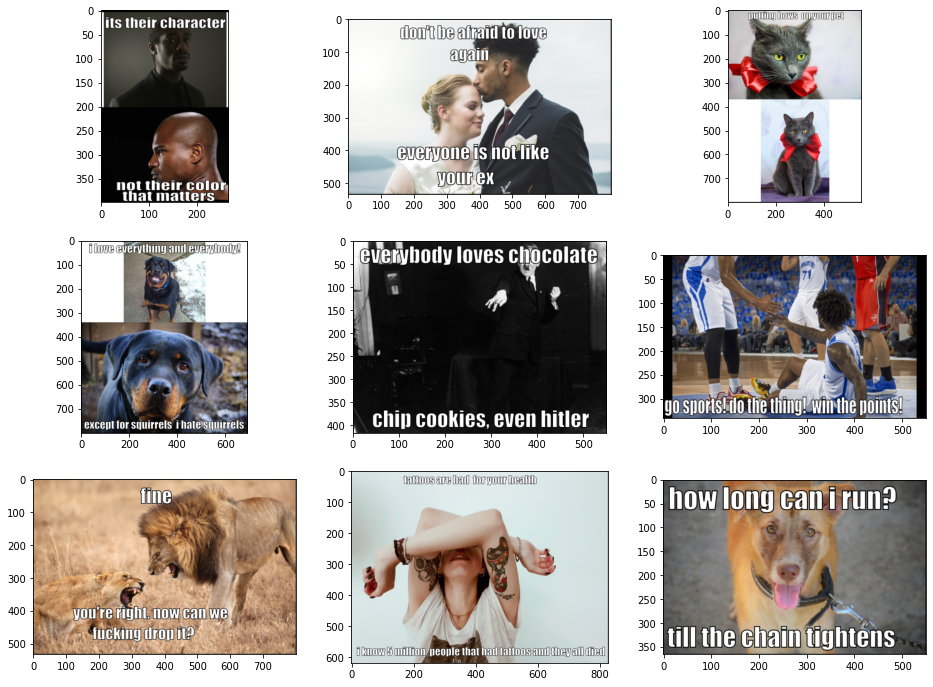

In [5]:
# Temporarily ensuring strings get printed without '...'
pd.set_option('display.max_colwidth', None)

# Using to_list to avoid index problems
img_path_series = train_df['img'][:9].to_list()
fig = plt.figure(figsize=[16,12])

for i in range(len(img_path_series)):
    a = fig.add_subplot(331 + i)
    img = mpimg.imread(base_path + img_path_series[i])
    imgplot = plt.imshow(img)
    
    # Print Text of meme from the DF
    print(train_df.loc[train_df['img'] == img_path_series[i]]['text'])

# Reset string option again
pd.reset_option('all')

### NON-HATEFUL MEMES ###

8491    i have 72 nukes aimed at israel if these damn j'ws don't stop pretending to be white i will wipe israel off the fucking map
Name: text, dtype: object
8492    when your sister only bangs black guys and gets knocked up ...and you literally become "a monkey's uncle!"
Name: text, dtype: object
8493    if you say these muslim protesters are violent.. they will kill you!!
Name: text, dtype: object
8494    when you re out in public, and your muslim acts up the dirty jew
Name: text, dtype: object
8495    nobody wants to hang auschwitz me
Name: text, dtype: object
8496    when god grants you a child after 20 years of your marriage and israel bombs him few years later
Name: text, dtype: object
8497    gays on social media: equality! body positivity! love love love! gays in real life: there is no place for her in our social circle
Name: text, dtype: object
8498    having a bad day? you could be a siamese twin attached to a gay brother who has a date and you're the only one with an ass
Nam

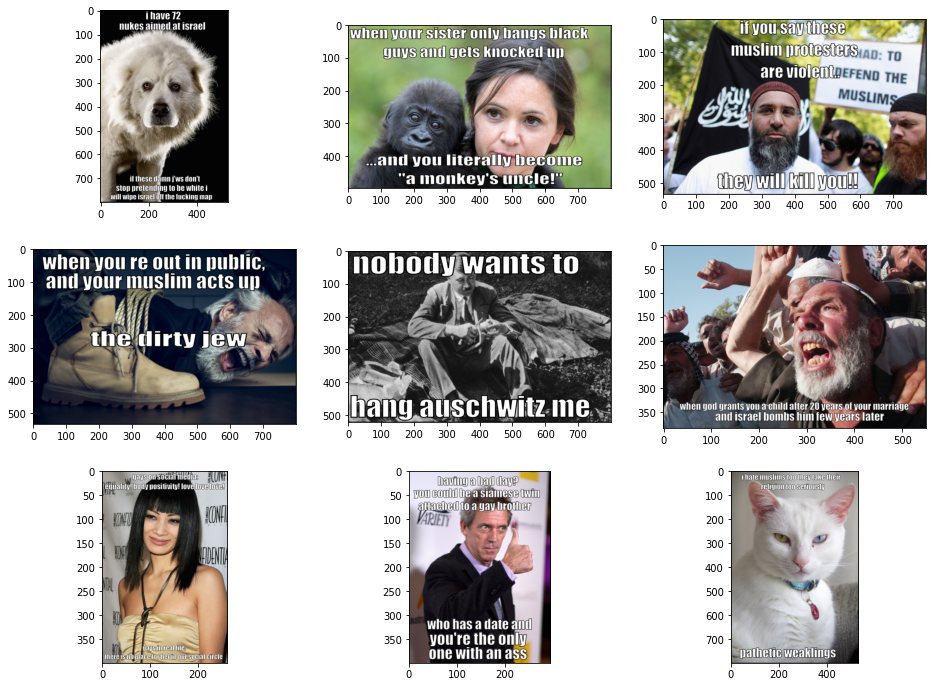

In [6]:
# Temporarily ensuring strings get printed without '...'
pd.set_option('display.max_colwidth', None)

# Using to_list to avoid index problems
img_path_series = train_df['img'][-9:].to_list()
fig = plt.figure(figsize=[16,12])

for i in range(len(img_path_series)):
    a = fig.add_subplot(331 + i)
    img = mpimg.imread(base_path + img_path_series[i])
    imgplot = plt.imshow(img)
    
    # Print Text of meme from the DF
    print(train_df.loc[train_df['img'] == img_path_series[i]]['text'])

# Reset string option again
pd.reset_option('all')

### HATEFUL MEMES ###

### Observations

- Rows are ordered by labels
- Images come in different sizes 
    - We might want to find out the max & min dimensions
- Memes might contain of 2 images
- Similar vocabulary throughout memes
- 'Mistakes': j'ws should be jews

## 3.2 Data Cleaning – 4 C's: Correcting, Completing, Creating & Converting

In this stage we will clean our data going through each of the 4 C's. While doing so, we need to be careful not to violate the Data License Agreement:

*(6) Participant will not:
modify, translate, or create any derivative works based upon the HM Dataset; (Source 4)*

As we are not allowed to modify the dataset, our model itself must do necessary modifications when it is fed input data, such as changing the size of the pictures. Nevertheless, we will list those possible modifications here.

1. **Correcting:** According to the forums the following list of image ids are incorrectly labeled: 

        01258, 01598, 01823, 02358, 02471, 02475, 02519, 02647, 02793, 03528, 03794, 04356, 04926, 05164, 05261, 05329, 05421, 05479, 06194, 06319, 06534, 06579, 06714, 06985, 07523, 08126, 08439, 08546, 08719, 09156, 09364, 09547, 09587, 10259, 10583, 10732, 10943, 12483, 12957, 13486, 14695, 14830, 15493, 16280, 17235, 19430, 23615, 23957, 27056, 27134, 27685, 28405, 30489, 31429, 32470, 32490, 34586, 34985, 35402, 36048, 36081, 37265, 37601, 42065, 43521, 43826, 46712, 54891, 56249, 56423, 59678, 61204, 72936, 83150, 92405, 92408, 92413, 93057 + 90471, 20568, 84269 + 91405, 95684, 27351

We might revisit this list & the forum to exclude those from training at a later step. (These are about 90 images, hence about 1% of our data). Another mistake of a doubled meme with different labels is below!

2. **Completing:** We do not have any null values nor incomplete pictures.


3. **Creating:** We might want our model to create features based on its input or make use of transformations for images.


4. **Converting:** We will need to convert the text & image to make it readable for our model. 
        Options for text: One-Hot Encoding (Unordered / Ordered), Index-Based Encoding, Word Embedding (word2vec / GloVe). 
        Options for image: Dim1xDim2x3 (RGB), Dim1xDim2x1 (Gray) Dims: Quadratic CenterCrop, Quadratic Overfit, Rectangle (Crop/Overfit) Other: Split memes with >1 images 

    Let us not forget the No-Free Lunch Theorem, i.e. there is no model that always works best. We will try multiple of these variations and then reiterate to figure out the best one. We will start with the text and lateron build a unimodal model purely predicting based on text to get a feeling for the difficulty of the problem. *As these conversions are highly intertwined with the actual model, we will do them at the very end, when building different models as part of EDA.*




# 4. Exploratory data analysis

Our data is not complex table data, so we can save some of the statistic correlations. We will, however, take a look at some text distributions. Whenever we have a new model with different tokenization, we will jump back to this step and explore.

In [7]:
# Setting up DFs

df_dict = {'train': train_df, 'dev': dev_df, 'test': test_df}
df_dict0 = {'train': train_df, 'dev': dev_df}

eda_tdt = pd.concat([df.assign(identity=key) for key,df in df_dict.items()])
eda_td = pd.concat([df.assign(identity=key) for key,df in df_dict0.items()])


# DF Dict:
# train_df, dev_df, test_df
# eda_tdt: Base df with train, dev, test
# 0, 1, 2, 3, 4: Various variations as specificed accordingly

## 4.1 Ratio-analysis

In this part we will try to correlate individual words with the label of the meme. Which words always appear in hateful memes? Which ones always in non-hateful memes? This might help in classification.

In [8]:
def copy_clean(df):
    
    df_copy = df.copy(deep=True)
    df_copy['text'] = df_copy['text'].str.replace('[{}]'.format(string.punctuation), '')
    df_copy['text'] = df_copy['text'].str.lower()
    
    return df_copy

eda_td0 = copy_clean(eda_td)

# Create Counter objects for words in hateful / non-hateful    
hate_counts = Counter()
nonhate_counts = Counter()
total_counts = Counter()

for index, row in eda_td0.iterrows():
    if row['label'] == 1:
        for word in row['text'].split(' '):
            hate_counts[word] += 1
            total_counts[word] += 1
    if row['label'] == 0:
        for word in row['text'].split(' '):
            nonhate_counts[word] += 1
            total_counts[word] += 1

# Ratio of how many hateful per non-hateful meme
train_ratio = len(eda_td0.loc[eda_td0['label'] == 1]) / len(eda_td0.loc[eda_td0['label'] == 0])

print(eda_td0['label'].value_counts())
print('Ratio: ', train_ratio)
print('-' * 50)
print(dev_df['label'].value_counts())

0    5700
1    3300
Name: label, dtype: int64
Ratio:  0.5789473684210527
--------------------------------------------------
1    250
0    250
Name: label, dtype: int64


In [9]:
print(hate_counts.most_common(30))
print('-' * 50)
print(nonhate_counts.most_common(30))

[('the', 1370), ('a', 1138), ('you', 1021), ('to', 854), ('i', 740), ('and', 671), ('of', 525), ('is', 523), ('when', 522), ('in', 509), ('your', 408), ('are', 343), ('it', 340), ('my', 328), ('for', 327), ('people', 286), ('this', 275), ('black', 265), ('they', 255), ('like', 253), ('white', 243), ('that', 238), ('but', 233), ('me', 232), ('with', 230), ('', 224), ('be', 207), ('have', 204), ('so', 202), ('on', 202)]
--------------------------------------------------
[('the', 1948), ('you', 1834), ('a', 1673), ('to', 1481), ('i', 1291), ('when', 903), ('and', 897), ('is', 820), ('in', 778), ('of', 753), ('your', 744), ('my', 597), ('for', 563), ('it', 526), ('this', 481), ('me', 436), ('that', 433), ('are', 412), ('like', 368), ('be', 365), ('on', 356), ('have', 355), ('with', 346), ('we', 340), ('im', 334), ('not', 328), ('but', 327), ('dont', 313), ('at', 305), ('people', 302)]


In [10]:
# Creating two different ways of scoring – One is one-based the other zero-based
hate_nonhate_ratio1 = Counter()
hate_nonhate_ratio0 = Counter()

# Note: Words with only one count get neutralized anyways due to the + 1 we use when dividing
count_hparam = 0

for word, count in total_counts.most_common():
    
    if count > count_hparam:
        hate_nonhate_ratio1[word] = hate_counts[word] / float(((nonhate_counts[word] * train_ratio) + 1))
    
    if count > count_hparam:
        hc = float(hate_counts[word])
        nhc = float(nonhate_counts[word] * train_ratio)
        
        # Hateful word
        if hc > nhc:
            hate_nonhate_ratio0[word] = np.log(hc / (nhc + 1))
        
        # Non-hateful word
        if nhc > hc:
            hate_nonhate_ratio0[word] = - np.log(nhc) / (hc + 1)
            
        
print('"the"-ratio should be close to 1 / 0: ', hate_nonhate_ratio1['the'], '///', hate_nonhate_ratio0['the'])
print('"jws"-ratio with only one count: ', hate_nonhate_ratio1['jws'], '///', hate_nonhate_ratio0['jws']) 

print('-' * 50)
print('One based:')
print(hate_nonhate_ratio1.most_common(20))
print('-' * 50)
print(hate_nonhate_ratio1.most_common()[-20:])
print('-' * 50)
print('-' * 50)
print('Zero based:')
print(hate_nonhate_ratio0.most_common(20))
print('-' * 50)
print(hate_nonhate_ratio0.most_common()[-20:])

"the"-ratio should be close to 1 / 0:  1.2136895603114655 /// 0.19366494355364955
"jws"-ratio with only one count:  1.0 /// 0.0
--------------------------------------------------
One based:
[('nigger', 24.0), ('word', 16.0), ('niggers', 16.0), ('akbar', 13.0), ('jews', 11.641618497109826), ('ernie', 11.0), ('christianity', 8.0), ('nword', 7.0), ('negro', 7.0), ('allahu', 7.0), ('faggot', 6.966666666666667), ('infidels', 6.0), ('beating', 6.0), ('buildings', 6.0), ('homosexuality', 6.0), ('bert', 6.0), ('gays', 5.905405405405405), ('minorities', 5.7), ('100', 5.560975609756097), ('transgender', 5.364705882352941)]
--------------------------------------------------
[('bite', 0.0), ('assert', 0.0), ('dominance', 0.0), ('militant', 0.0), ('martyr', 0.0), ('wellbeing', 0.0), ('stain', 0.0), ('beets', 0.0), ('valuation', 0.0), ('mileage', 0.0), ('swiftly', 0.0), ('although', 0.0), ('rose', 0.0), ('boring', 0.0), ('ooof', 0.0), ('salvation', 0.0), ('bling', 0.0), ('prosthetic', 0.0), ('bondin

- Lots of hateful words correlate with hateful memes, however some correlations are rather out of place, such as "word" being correlated with hatefulness

## 4.2 Word length analysis

Is there a difference in the length of Hateful / Nonhateful words?

In [12]:
hate_lens = []
nhate_lens = []
cut = 0.5


for k, v  in hate_nonhate_ratio0.items():
    if v > cut:
        hate_lens.append(len(k))
    elif v < -cut:
        nhate_lens.append(len(k))

print(sum(hate_lens)/len(hate_lens))
print(sum(nhate_lens)/len(nhate_lens))

# 0.2: 6.66 vs 6.17 // 0.5: 6.8 vs 5.98 // 0.7: 5.99 6 vs 6.10 // 0.4: 6.77 vs 6.36

6.786190187764991
5.9941176470588236


## 4.3 Text-Length Analysis

      id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   

                                                text  len  
0   its their character not their color that matters   48  
1  don't be afraid to love again everyone is not ...   58  
--------------------------------------------------
label
0    58.489725
1    68.483607
Name: len, dtype: float64
Double-check: 68.48360655737704
label
0    53.444
1    55.136
Name: len, dtype: float64
Test_df: 55.468
--------------------------------------------------


<AxesSubplot:title={'center':'Dev Txt Len PDF'}, ylabel='Density'>

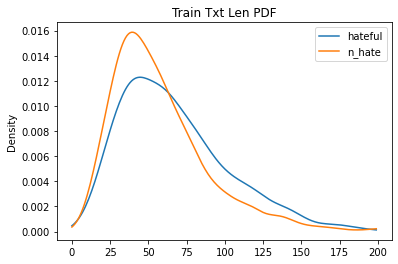

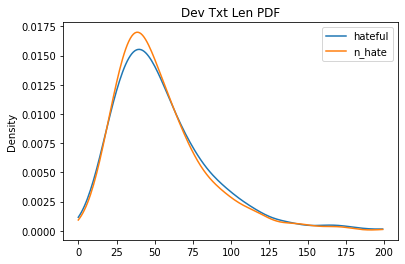

In [14]:
# Probability Density Functions of text length
# We use KDE as it's non-parametric, hence it does not assume any underlying distribution

# Creating copy of train_df & dev_df with length feature

trlen_df = train_df.copy()
dvlen_df = dev_df.copy()
trlen_df['len'] = trlen_df['text'].apply(len)
dvlen_df['len'] = dvlen_df['text'].apply(len)
print(trlen_df.head(2))
print('-'*50)

# Checking the averages for hate/nonhateful
print(trlen_df.groupby(['label'])['len'].mean())
print('Double-check:', train_df.loc[train_df['label'] == 1]['text'].apply(len).mean())
print(dvlen_df.groupby(['label'])['len'].mean())
print('Test_df:', test_df['text'].apply(len).mean())
print('-'*50)

# Plotting the PDF
pd.DataFrame({'hateful': trlen_df.loc[trlen_df['label'] == 1]['len'], 
              'n_hate': trlen_df.loc[trlen_df['label'] == 0]['len']}).plot.kde(title='Train Txt Len PDF', 
                                                                                ind=range(200))

pd.DataFrame({'hateful': dvlen_df.loc[dvlen_df['label'] == 1]['len'], 
              'n_hate': dvlen_df.loc[dvlen_df['label'] == 0]['len']}).plot.kde(title='Dev Txt Len PDF',
                                                                                 ind=range(200))

- Difference is not meaningful enough

## 4.4 Transformer Model Exploration - BERT-Tokenizer & Vocabulary

In [15]:
# Loading several BERT tokenizers with different vocabs.
print('Loading BERT tokenizer...')
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print('Loading Hate tokenizer...')
# Loading a tokenizer trained on hatespeech
tokenizer_hate = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")

print('Loading Roberta Base tokenizer...')
# Loading Roberta Base
tokenizer_robbase = AutoTokenizer.from_pretrained("roberta-base")

print('Loading XLM Roberta Large tokenizer...')
# Loading XLM Roberta Large
tokenizer_xlmrob = AutoTokenizer.from_pretrained("xlm-roberta-large")

print('Loading ALBERT Base tokenizer')
# Loading Albert tokenizer Base
tokenizer_albert = AutoTokenizer.from_pretrained("albert-base-v2")

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading Hate tokenizer...


Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/152 [00:00<?, ?B/s]

Loading Roberta Base tokenizer...


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loading XLM Roberta Large tokenizer...


Downloading:   0%|          | 0.00/513 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Loading ALBERT Base tokenizer


Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [16]:
# Vocab sizes & example encodings

print('BERT-BASE-UNCASED:', len(tokenizer_bert.vocab.keys()))
print('Original: ', train_df['text'][10])
print('Tokenized: ', tokenizer_bert.tokenize(train_df['text'][10]))
print('Token IDs: ', tokenizer_bert.convert_tokens_to_ids(tokenizer_bert.tokenize(train_df['text'][10])))
print('-'*50)

print('HATE-CNERG:', len(tokenizer_hate.vocab.keys()))
print('Original: ', train_df['text'][10])
print('Tokenized: ', tokenizer_hate.tokenize(train_df['text'][10]))
print('Token IDs: ', tokenizer_hate.convert_tokens_to_ids(tokenizer_hate.tokenize(train_df['text'][10])))
print('-'*50)

print('ROBERTA-BASE:', len(tokenizer_robbase.get_vocab()))
print('Original: ', train_df['text'][10])
print('Tokenized: ', tokenizer_robbase.tokenize(train_df['text'][10]))
print('Token IDs: ', tokenizer_robbase.convert_tokens_to_ids(tokenizer_robbase.tokenize(train_df['text'][10])))
# Note: Roberta works best with a dummy space before the very first word (jew)
# [CLS] + prefix_space + tokens + [SEP] + padding
print('-'*50)

# Note: XLM & AlBERT prepend the dummy space automatically
print('XLM-ROBERTA:', len(tokenizer_xlmrob.get_vocab()))
print('Original: ', train_df['text'][10])
print('Tokenized: ', tokenizer_xlmrob.tokenize(train_df['text'][10]))
print('Token IDs: ', tokenizer_xlmrob.convert_tokens_to_ids(tokenizer_xlmrob.tokenize(train_df['text'][10])))
print('-'*50)

print('ALBERT:', len(tokenizer_albert.get_vocab()))
print('Original: ', train_df['text'][10])
print('Tokenized: ', tokenizer_albert.tokenize(train_df['text'][10]))
print('Token IDs: ', tokenizer_albert.convert_tokens_to_ids(tokenizer_xlmrob.tokenize(train_df['text'][10])))
print('-'*50)

BERT-BASE-UNCASED: 30522
Original:  jew mad? get fuhrerious!
Tokenized:  ['jew', 'mad', '?', 'get', 'fu', '##hrer', '##ious', '!']
Token IDs:  [16522, 5506, 1029, 2131, 11865, 17875, 6313, 999]
--------------------------------------------------
HATE-CNERG: 105879
Original:  jew mad? get fuhrerious!
Tokenized:  ['je', '##w', 'mad', '?', 'get', 'fuhrer', '##ious', '!']
Token IDs:  [10149, 10650, 24603, 136, 13168, 52709, 22173, 106]
--------------------------------------------------
ROBERTA-BASE: 50265
Original:  jew mad? get fuhrerious!
Tokenized:  ['jew', 'Ġmad', '?', 'Ġget', 'Ġf', 'uh', 're', 'rious', '!']
Token IDs:  [34929, 7758, 116, 120, 856, 2957, 241, 39554, 328]
--------------------------------------------------
XLM-ROBERTA: 250002
Original:  jew mad? get fuhrerious!
Tokenized:  ['▁je', 'w', '▁mad', '?', '▁get', '▁fu', 'hre', 'rious', '!']
Token IDs:  [55, 434, 17946, 32, 2046, 5639, 13520, 93905, 38]
--------------------------------------------------
ALBERT: 30000
Original:  j

In [17]:
# Some tokenization comparison of the dummy space & WordPiece (BERT) & SentencePiece (Rob & AlBERT)
print(tokenizer_bert.tokenize('airplane'))
print(tokenizer_robbase.tokenize(' airplane')) 
print(tokenizer_albert.tokenize('airplane')) # Prepended automatically

print(tokenizer_bert.tokenize('recreate')) # Disadvantage of subwords
print(tokenizer_albert.tokenize('recreate'))

['airplane']
['Ġairplane']
['▁airplane']
['rec', '##reate']
['▁recreate']


In [18]:
# How many tokens (correlates with compute & probably worse performance)
# does each tokenizer need for all memes?
full_text = (" ").join(eda_tdt.text.values.tolist())

print('LEN TEXT:', len(full_text.split(' ')))
print('LEN BERT:', len(tokenizer_bert.tokenize(full_text)))
print('LEN CNERG: ', len(tokenizer_hate.tokenize(full_text)))
print('LEN ROB: ', len(tokenizer_robbase.tokenize(full_text)))
print('LEN XLMROB: ', len(tokenizer_xlmrob.tokenize(full_text)))
print('LEN ALBERT: ', len(tokenizer_albert.tokenize(full_text)))

LEN TEXT: 115410
LEN BERT: 142858


Token indices sequence length is longer than the specified maximum sequence length for this model (149859 > 512). Running this sequence through the model will result in indexing errors


LEN CNERG:  149859


Token indices sequence length is longer than the specified maximum sequence length for this model (140412 > 512). Running this sequence through the model will result in indexing errors


LEN ROB:  140412


Token indices sequence length is longer than the specified maximum sequence length for this model (155641 > 512). Running this sequence through the model will result in indexing errors


LEN XLMROB:  155641


Token indices sequence length is longer than the specified maximum sequence length for this model (145059 > 512). Running this sequence through the model will result in indexing errors


LEN ALBERT:  145059


In [21]:
# How does BERT handle hashtags? 
# len(full_df.loc[train_df.text.str.contains('\#')]) somehow gives wrong ones

# Find all texts w/ #'s
hashtags = [re.findall('#\w+', i) for i in eda_tdt.text.values]
real_hs = []
for hashtag in hashtags:
    if hashtag:
        real_hs.append(hashtag)
        
print(len(real_hs))
print("-"*50)
print("Example Hashtags")
print(real_hs)
print("-"*50)
print("Problem of tokenizing Hashtags, as there are no spaces...")
print(tokenizer_bert.tokenize('#justnorthkoreathings'))

35
--------------------------------------------------
Example Hashtags
[['#666'], ['#k'], ['#23'], ['#lagostoibadan'], ['#treason'], ['#psychopaths'], ['#unapologetically'], ['#neverforget', '#christianity'], ['#selfie'], ['#iaoh'], ['#irl'], ['#france'], ['#justnorthkoreathings'], ['#thanksgivingclapback'], ['#whiteprivilege'], ['#basketballsareflat'], ['#goatlivesmatter'], ['#terrorist'], ['#fukislam'], ['#selfie'], ['#whiteprideworldwide'], ['#freesentsov', '#freekolchenko'], ['#yolo'], ['#nevertrump'], ['#usher'], ['#2'], ['#666'], ['#astrazine'], ['#islamistheproblem'], ['#23'], ['#roots'], ['#roots'], ['#metoo'], ['#23'], ['#treason']]
--------------------------------------------------
Problem of tokenizing Hashtags, as there are no spaces...
['#', 'just', '##nor', '##th', '##kor', '##ea', '##thing', '##s']


In [32]:
# Adding tokens to the end

# Create a 2nd dummy tokenizer
tokenizer_bert_test = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

print("Vocab len", len(tokenizer_bert_test.vocab))
print("-"*50)
print("Tokenization problem", tokenizer_bert_test.tokenize('committedhoe handjob niggacommitted xlscommitted'))
print("-"*50)
num = tokenizer_bert_test.add_tokens(['hoe', 'handjob', 'nigga'])
print("Added ", num, " new tokens.")
num = tokenizer_bert_test.add_special_tokens({'unk_token': 'committed'})

print(len(tokenizer_bert_test.vocab))
print("-"*50)
print("Problem solved", tokenizer_bert_test.tokenize('carcommittedhoe handjob niggacommitted xlscommitted'))


Vocab len 30522
--------------------------------------------------
Tokenization problem ['committed', '##hoe', 'hand', '##jo', '##b', 'ni', '##gga', '##com', '##mit', '##ted', 'xl', '##sco', '##mm', '##itte', '##d']
--------------------------------------------------
Added  3  new tokens.
30522
--------------------------------------------------
Problem solved ['car', 'committed', 'hoe', 'handjob', 'nigga', 'committed', 'xl', '##s', 'committed']


The best way to adjust the vocab is altering the .txt file & rebuilding the tokenizers. Via this we can also add subwords (## as prepend) & normal words.

In [36]:
### How different are the keys? Easy to load into our models? 

from transformers import AutoModel
bert_struc = AutoModel.from_pretrained("bert-base-uncased")
for key, value in bert_struc.state_dict().items():
    print(key)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

embeddings.position_ids
embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.la

In [ ]:
import torchviz
dot = torchviz.make_dot(model(), params=dict(model.named_parameters()))
dot.format = 'png'
dot.render(os.path.join(args.out, args.exp))

In [38]:
# HM Vocab - 
# Note: We do not need to strip any punctuation as BERT-like tokenizers are used to handle it
# But here it serves the purpose of being able to compare the HM Vocab versus the Vocab of our BERT models

eda_tdt0 = eda_tdt.copy()

eda_tdt0['text'] = eda_tdt0['text'].str.replace('[{}]'.format(string.punctuation), '')
eda_tdt0['tokens'] = eda_tdt0['text'].str.split(' ')
    
# Create Counter objects for every word - The count & the ratios we prev. calculated will be a proxy for its importance 
total_counts_full = Counter()

for index, row in eda_tdt0.iterrows():
    for word in row['text'].split(' '):
        total_counts_full[word] += 1

vocab_hm = list(total_counts_full.keys())
print(len(vocab_hm))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


9692


In [39]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        
        return distance[row][col]

In [40]:
# Words Bert lacks! 

# Example of a word present in data, which might lose its meaning
print(tokenizer_bert.tokenize('handjob'))
print('Counts as proxy for importance:', total_counts['handjob'])

# Streamline:

# A Get all unique words in HM

# B Remove words present 1-to-1 in BERT

# C Remove plurals 

# D Remove words present as singular in BERT

# E Remove numbers 

# F Remove words where letters are replaced w/ numbers

# G Remove words tokenized into x + ##ing

# H Removing words tokenized into two meaningful tokens (By going through all & defining exceptions)



### A ### 
print(len(set(vocab_hm)))


### B ###
left0 = (set(vocab_hm) - set(tokenizer_bert.vocab.keys()))
print(len(left0))

### C ###
left1 = set()
for word in left0:
    if len(word) < 1:
        continue
    if word[-1] == 's':
        left1.add(word[:-1])
    else:
        left1.add(word)
   
print(len(left1))


### D ###
left2 = left1 - set(tokenizer_bert.vocab.keys())
print(len(left2))


### E ###
def int_filter(iterable):
    for v in iterable:
        try:
            int(v)
            continue # Skip these
        except ValueError:
            yield v # Keep these

left3 = set(int_filter(left2))
print(len(left3))


### F ###
# Replacing e.g. 0mar with Omar; If word exists: 0 > O; 3 > E; 1 > I; 9 > G
# n1gg3r; ni99er

remove_set = set()

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

num_dict = {'0': 'o', '1': 'i', '3': 'e', '4': 'a', '9': 'g'}

for v in left3:
    if (hasNumbers(v)) & (len(v) > 3):
        
        new_v = ''
        
        for char in v:  
            if (char.isdigit()) & (char in num_dict.keys()):  
                char = num_dict[char]
      
            new_v += char
            
        if new_v != v:
            if (new_v in set(tokenizer_bert.vocab.keys())) or (new_v in set(vocab_hm)):
                print('Replacing', v, 'with', new_v)
                remove_set.add(v)
            #else:
                #print('Could not find for ', new_v)
        
left4 = left3 - remove_set
print(len(left4))

### G ###
# Keep in mind: fisting, raping, fingering > Perhaps at some point add_tokens for these; 
# raping could be replaced w/ rape

ings = set()
for v in left4:
    tokens = tokenizer_bert.tokenize(v)
    
    if (len(tokens) == 2) & (tokens[-1] == '##ing'):
        
        ings.add(v)
        
left5 = left4 - ings
print(len(left5))


### H ###

toks0 = []
toks2 = []
toks3 = []
toks4 = []

words0 = []
words2 = []
words3 = []
words4 = []

for v in left5:
    tokens = tokenizer_bert.tokenize(v)
    
    toks0.append(tokens)
    words0.append(v)
    
    if (len(tokens) == 2):
        
        toks2.append(tokens)
        words2.append(v)
          
    elif (len(tokens) == 3):
        
        toks3.append(tokens)
        words3.append(v)
        
    elif (len(tokens) == 4):
        
        toks4.append(tokens)
        words4.append(v)


# Going through all in sets of 50

toks2_freq = sorted(toks2, reverse=True, key=lambda x: total_counts_full[words2[toks2.index(x)]])
#print(toks2_freq[650:700]) # Stopped at 700
left6 = left5 - set(words2)
print(len(left6))

toks3_freq = sorted(toks3, reverse=True, key=lambda x: total_counts_full[words3[toks3.index(x)]])
#print(toks3_freq[:100])
left7 = left6 - set(words3)
print(len(left7))

toks4_freq = sorted(toks4, reverse=True, key=lambda x: total_counts_full[words4[toks4.index(x)]])
#print(toks4_freq)
left8 = left7 - set(words4)
print(len(left8))



# Base frequencies
toks0_freq = sorted(toks0, reverse=True, key=lambda x: total_counts_full[words0[toks0.index(x)]])
print(toks0_freq[:100])



### EXTRA ###

# Tokenize all and see what tokens are most frequent
token_counts = Counter()
for word in left4:
    tokens = tokenizer_bert.tokenize(word)
    for token in tokens:
        token_counts[token] += 1
        
    #if '##d' in tokens:   
    #    print(tokens)

# Combined words
i = 0
for k in sorted(left5, key=len, reverse=True):
    i += 1
    #print(k, tokenizer_bert.tokenize(k), tokenizer_albert.tokenize(k))
    if i == 1:
        break
        

# Cases
# ##t: weren t; don t; ain t; aren t; wouldn t; haven t; didn t; did t; wasn t; couldn t; can t
# ##er: fuck er; stupid er; drink er; sweet er; 
# ##e: bitch e; mosque e; ho e;  bath e
# ##y: smell y; sting y; sketch y; sneak y; jews y; sweet y; 
# ##ing: swim ing; bitch ing; jack ing; gossip ing; finger ing

# Not easy:
# We do not want to overfit too much by e.g. sorting exactly which words we keep & dont
# At the same time we cannot just ignore all ings as fingering as definitely something different than finger + ing
                    # Or is it? Phaps BERT knows from its attention that the ing w/ finger has aspecial meaning
    # -> We could experiment here by leaving all else equal just setting fingering to a sep token
    # -> We should also experiment with setting nigga to a sep unk or replacing the text with nigger or a known word

['hand', '##jo', '##b']
Counts as proxy for importance: 5
9692
3214
3109
2788
2739
Replacing ni99er with nigger
Replacing 0mar with omar
Replacing n1gg3r with nigger
2736
2695
1124
285
67
[['don', '##t'], ['your', '##e'], ['can', '##t'], ['dish', '##wash', '##er'], ['doesn', '##t'], ['tran', '##ny'], ['didn', '##t'], ['they', '##re'], ['isn', '##t'], ['iv', '##e'], ['aren', '##t'], ['ain', '##t'], ['il', '##han'], ['you', '##ve'], ['wal', '##mart'], ['re', '##tar', '##ded'], ['you', '##ll'], ['fuck', '##er'], ['dia', '##per'], ['lo', '##l'], ['me', '##me'], ['fuck', '##in'], ['won', '##t'], ['ya', '##ll'], ['ni', '##gger'], ['haven', '##t'], ['wasn', '##t'], ['shouldn', '##t'], ['stone', '##d'], ['rashid', '##a'], ['hi', '##ja', '##b'], ['they', '##ll'], ['sha', '##ria'], ['t', '##lai', '##b'], ['couldn', '##t'], ['def', '##und'], ['rap', '##ist'], ['nah', '##ir'], ['cooke', '##r'], ['k', '##fc'], ['jen', '##ner'], ['mother', '##fu', '##cker'], ['ma', '##am'], ['id', '##k'], ['hum', '#

In [41]:
# Setting up a replacement dict

# Dict for misspellings & translations - 
# Note: we're losing some of the disrespect when e.g. turning tranny into transexual;

# Careful with: kkk, hoe (not included; as also used as normal hoe); whit - once white, with
# Often misspelled words are really important for e.g. chinese dialect or foreigners

spell_dict = {'separation': ['seperation'],
              'separate': ['seperate'],
              'separately': ['seperately'],
              'because': ['beacuse', 'cuz', 'bcuz'],
              'people': ['peopie', 'ppl'],
              'paranoid': ['paraniod'],
              'auschwitz': ['auchschwitz'],
              'unemployment': ['uneployment'],
              'illegal': ['ilegal'], 
              'everybody': ['everyrody'], 
              'flamethrower': ['flammenwerfer'],
              'sanctuary': ['sancuary'],
              'chicken': ['chiken', 'chickin'],
              'grandmother': ['grandmoth'],
              'bastard': ['basterd'],
              'muslim': ['moslem'], 
              'muslims': ['moslems', 'buslims'],
              'embarrassing': ['embarassin', 'embarassing'],
              'revive': ['rvive'], 
              'homelessness': ['homelessnes'], 
              'america': ['amerika'], 
              'sausage': ['wurst'],
              'reporting': ['reportin'],
              'department of justice': ['doj'], 
              'burka': ['burkha', 'burqa', 'burqha', 'niqab'],
              'nigger': ['niqqa', 'niqqer', 'nigga', 'niggo', 'nword', 'ni99as', 'n1994s', 'n1gg4s', 'n1ggas', 'nigg4s', 'n1gg3r'],
              'niggers': ['niqqas', 'niqqers', 'niggas', 'niggos', 'ni99as', 'n1994s', 'n1gg4s', 'n1ggas', 'nigg4s', 'n1gg3rs'],
              'facebook': ['fb'],
              'ku klux klan': ['kkk', 'klu klux klan'],
              'fucking': ['fkn', 'fckn', 'fing'],
              'g-spot': ['gspot'],
              'dog': ['dawg'],
              'year': ['yr'],
              'communist': ['commie'],
              'they': ['dey'],
              'wait a moment': ['wayment'], 
              'make america great again': ['maga'],
              'democratic national comittee': ['dnc'],
              'lying': ['lyin'],
              'goat shit': ['goatshit'],
              'committed': ['commited'],
              'Attention deficit hyperactivity disorder': ['adhd'],
              'shit': ['sht'],
              'having': ['havin'],
              'rolling': ['rollin'],
              'hating': ['hatin'],
              'history': ['histoy'],
              'bro': ['bru'],
              'motherfuckers': ['mafuckas', 'mafucka' 'muthafucka', 'muthafuckas'],
              'losing': ['loosing'],
              'female': ['fmale'],
              'privilege': ['privelege'], 
              'chocolate': ['choco'],
              'bitch': ['btch, biatch'],
              'school': ['skul'], 
              'girlfriend': ['gf'],
              'understand': ['undertan'],
              'achieve': ['acheive'],
              'sweating': ['sweatin'],
              'give me': ['gimme'], 
              'arabic': ['aribic'],
              'pictures': ['pix'],
              'gangster': ['gangsta'],
              'world war two': ['ww2', 'wwii', 'wwtwo'],
              'mandatory': ['manditory'],
              'government': ['goverment'],
              'neither': ['niether'],
              'islamphobia': ['islamophobia'],
              'getting': ['gettin']}

# Removing loop
remove_set = set()
tr_unused = set(spell_dict.keys())

for v in vocab_hm:
    if any(v in val for val in spell_dict.values()):
        keys = [key for key, value in spell_dict.items() if v in value]
        
        print('Replacing', v, 'with', keys[0]) 
        if keys[0] in tr_unused:
            tr_unused.remove(keys[0])
        
        if keys[0] in set(tokenizer_bert.vocab.keys()):
            remove_set.add(v)
        else:
            print(tokenizer_bert.tokenize(keys[0]))

leftX = left5 - remove_set
print((len(leftX)))

print('-'*50)

# Dict for replacements - this is going one step further & aggreating more words to ease learning
rep_dict = {'movie database': ['imdb'], 
            'facebook': ['linkedin', 'snapchat', 'instagram'], 
            'bitch': ['biatch', 'cunt', 'slut', 'thot'], 
            'bitchs': ['biatches', 'cunts', 'sluts', 'hoes'], 
            'nigger': ['niqqa', 'niqqer', 'nigga', 'nibba', 'niggo', 'nword', 'nikker'],
            'niggers': ['niqqas', 'niqqers', 'niggas', 'niggos', 'nikkers'],
            'transgender': ['tranny', 'transexual', 'shemale', 'transsexual', 'transwoman'],
            'transgender': ['trannys', 'trannies' 'transexuals', 'shemales', 'transsexuals', 'transwomen'], 
            'naughty': ['horny'],
            'transgender grandparent': ['tranpa'],
            'anal': ['rectal'],
            'masturbate': ['wanking', 'masturbating', 'jack off', 'fap'], 
            'muslim cloth': ['hijab', 'hiyab', 'burka', 'burkha', 'burqa'],
            'mohammed': ['muhamed', 'muhammed', 'mohamed'],
            'idiot': ['faggot', 'fag', 'retard'],
            'muslim': ['musslamic'],
            'drugs': ['meth'], 
            'mentally ill': ['retarded', 'autistic'],
            'sex party': ['threesome'],
            'person ejecting squirt': ['squirter'],
            'sandwich': ['sammich'],
            'monkey': ['harambe', 'gorilla'],
            'meat head': ['meathead']}


remove_set0 = set()
tr_unused0 = set(rep_dict.keys())
for v in vocab_hm:
    if any(v in val for val in rep_dict.values()):
        keys = [key for key, value in rep_dict.items() if v in value]
        
        print('Replacing', v, 'with', keys[0]) 
        if keys[0] in tr_unused0:
            tr_unused0.remove(keys[0])
        
        if keys[0] in set(tokenizer_bert.vocab.keys()):
            remove_set0.add(v)
        else:
            print(tokenizer_bert.tokenize(keys[0]))

# Reasons for integrating all normal words also as hashes:
# farmersonlycom 'white privilege': ['whiteprivilege']

# Words missing completely
# burka, hijab / hiyab 
# ilhan (omar) (person), (linda sarsour) rashida (person), tlaib ocasto cortez (person), 
# sharia (law) (phaps rplce with islamic law), nahir (name), jenner (person), ariana grande, trudeau. biden, osama
# addo tarrant burell zakir naik musk zuckerberg

Replacing chiken with chicken
Replacing dawg with dog
Replacing adhd with Attention deficit hyperactivity disorder
['attention', 'deficit', 'hyper', '##act', '##ivity', 'disorder']
Replacing fkn with fucking
Replacing chickin with chicken
Replacing doj with department of justice
['department', 'of', 'justice']
Replacing ppl with people
Replacing wayment with wait a moment
['wait', 'a', 'moment']
Replacing gspot with g-spot
['g', '-', 'spot']
Replacing gimme with give me
['give', 'me']
Replacing wwii with world war two
['world', 'war', 'two']
Replacing sancuary with sanctuary
Replacing manditory with mandatory
Replacing lyin with lying
Replacing everyrody with everybody
Replacing burqa with burka
['bu', '##rka']
Replacing yr with year
Replacing nword with nigger
['ni', '##gger']
Replacing maga with make america great again
['make', 'america', 'great', 'again']
Replacing niether with neither
Replacing ww2 with world war two
['world', 'war', 'two']
Replacing skul with school
Replacing gf 

In [42]:
# Printing the dicts w/o bias from dev / test

kernel_sp = spell_dict.copy()
for k in tr_unused:
    del kernel_sp[k]

print(kernel_sp)


print('-'*50)

kernel_rp = rep_dict.copy()
for k in tr_unused0:
    del kernel_rp[k]

print(kernel_rp)

{'separation': ['seperation'], 'separate': ['seperate'], 'separately': ['seperately'], 'because': ['beacuse', 'cuz', 'bcuz'], 'people': ['peopie', 'ppl'], 'paranoid': ['paraniod'], 'auschwitz': ['auchschwitz'], 'unemployment': ['uneployment'], 'everybody': ['everyrody'], 'flamethrower': ['flammenwerfer'], 'sanctuary': ['sancuary'], 'chicken': ['chiken', 'chickin'], 'grandmother': ['grandmoth'], 'muslim': ['moslem'], 'muslims': ['moslems', 'buslims'], 'embarrassing': ['embarassin', 'embarassing'], 'america': ['amerika'], 'sausage': ['wurst'], 'reporting': ['reportin'], 'department of justice': ['doj'], 'burka': ['burkha', 'burqa', 'burqha', 'niqab'], 'nigger': ['niqqa', 'niqqer', 'nigga', 'niggo', 'nword', 'ni99as', 'n1994s', 'n1gg4s', 'n1ggas', 'nigg4s', 'n1gg3r'], 'niggers': ['niqqas', 'niqqers', 'niggas', 'niggos', 'ni99as', 'n1994s', 'n1gg4s', 'n1ggas', 'nigg4s', 'n1gg3rs'], 'facebook': ['fb'], 'ku klux klan': ['kkk', 'klu klux klan'], 'fucking': ['fkn', 'fckn', 'fing'], 'g-spot': [

In [48]:
# Applying replacements

train_df0 = train_df.copy()

def rep_v(text):
    for k, v in spell_dict.items():
        for op in v:
            text = text.replace(op,k)
            
    return text

train_df0.text = train_df0.text.apply(rep_v)
train_df0.head()

id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  
0   its their character not their color that matters  
1  don't be afraid to love again everyone is not ...  
2                           putting bows on your pet  
3  i love everything and everybody! except for sq...  
4  everybody loves chocolatelate chip cookies, ev...

In [49]:
train_df0.loc[train_df0.text.str.contains('tranny')].text

49      when a porn video features a tranny but then' ...
65      when you beat the shit out of the tranny hooke...
272     how many times do we have to teach you this le...
296     the only "perferred pronouns" a tranny needs i...
340       don't get me started about your tranny problems
                              ...                        
8214                         greetings tranny time to die
8308    guys out there can spot fake jordans, but can'...
8337    opens inbox "lemme suck your dick" goes to pro...
8438    da look dog gave mina after they fucked that t...
8439    what do chevy trucks have in common with their...
Name: text, Length: 89, dtype: object

- Building models with the above replacements did not improve performance - It seems like BERT is robust to misspellings!

In [54]:
# Calculate some metrics for each word

#def calc_metrics():

left_dict = {}
i=0

for word in left4:

    i+=1
    values = []

    # How many subwords
    count = len(tokenizer_bert.tokenize(word))
    values.append(count)

    # Levenshtein distance to closest BERT word & the word
    lev_ratio = 0
    lev_word = None
    for key in tokenizer_bert.vocab.keys():
        cur_ratio = levenshtein_ratio_and_distance(word, key, ratio_calc=True)
        if cur_ratio > lev_ratio:
            lev_ratio = cur_ratio
            lev_word = key
    values.append(lev_ratio)
    values.append(lev_word)

    # Hate ratio
    hate_ratio = 0
    if word in hate_nonhate_ratio0:
        hate_ratio = hate_nonhate_ratio0[word]
    values.append(hate_ratio)

    left_dict[word] = values

    if i == 30:
        break
    
# 2 possibilities to treat the final words:
# 1 - Replace with closest Levenshtein
# 2 - Put at UNUSED POS

# Probably a mix will perform best -- e.g. levenshteinat 0.95; UNUSED for rest 
# (-Then with UNUSED PHAPS EXPERIENCE) w/ setting embedding
#word_one = [key for key in total_counts.keys() if total_counts[key] == 1

In [56]:
left_dict

{'begum': [2, 0.8333333333333334, 'belgium', 0.5465437063680699],
 'announcment': [4, 0.9565217391304348, 'announcement', 0.5465437063680699],
 'disloyal': [4, 0.7692307692307693, 'loyal', 0.5465437063680699],
 'brutalize': [2, 0.8, 'brutal', 0],
 'bleach': [3, 0.9090909090909091, 'beach', -0.8397506547518208],
 'stork': [3, 0.8, 'story', 0.5465437063680699],
 'styrofoam': [5, 0.7058823529411765, 'restroom', -0.456758402495715],
 'mussie': [3, 0.8, 'muse', 0.0],
 'witchu': [2, 0.9090909090909091, 'witch', 0.5465437063680699],
 'box360': [3, 0.6666666666666666, 'box', 0.5465437063680699],
 'nadler': [2, 0.9090909090909091, 'adler', 0],
 'transsport': [2, 0.9473684210526315, 'transport', 0],
 'munt': [2, 0.8888888888888888, 'mount', 0.5465437063680699],
 'victimize': [2, 0.8, 'victim', 0.0],
 'veterano': [2, 0.9333333333333333, 'veteran', 0],
 'acheive': [2, 0.8571428571428571, 'achieve', 0.5465437063680699],
 'deformity': [3, 0.7777777777777778, 'dormitory', 0.5465437063680699],
 'crimn

- The levenshtein ratio may help detect some writing mistakes
- The higher we set the ratio cutoff the less false negatives we will get

In [57]:
# What seq len is necessary?

max_len = 0

# For every sentence...
for row in train_df['text']:
    
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer_bert.encode(row, add_special_tokens=True)
    
    # Correct encoding?
    if max_len == 0:
        print(row)
        print(tokenizer_bert.decode(input_ids))
        

    # Update the maximum sentence length.
    cur_len = len(input_ids)
    max_len = max(max_len, cur_len)
    
    # Print longest sentence
    if cur_len == 88:
        print(tokenizer_bert.decode(input_ids))
        print(tokenizer_bert.tokenize(row))
        

print('Max sentence length: ', max_len)

its their character not their color that matters
[CLS] its their character not their color that matters [SEP]
[CLS] housing, free gas, free electricity, free healthcare and free education for my wives and children. to show graditude for your generosity, i'll groom your 12 year old daughters, blow up your trains, planes and buses and preach hate through a dawah stall in your local city and town centres with the purpose of turning your generous country into the same shithole i originally took refuge from, allahu akbar! [SEP]
['housing', ',', 'free', 'gas', ',', 'free', 'electricity', ',', 'free', 'healthcare', 'and', 'free', 'education', 'for', 'my', 'wives', 'and', 'children', '.', 'to', 'show', 'gr', '##adi', '##tu', '##de', 'for', 'your', 'generosity', ',', 'i', "'", 'll', 'groom', 'your', '12', 'year', 'old', 'daughters', ',', 'blow', 'up', 'your', 'trains', ',', 'planes', 'and', 'buses', 'and', 'preach', 'hate', 'through', 'a', 'da', '##wa', '##h', 'stall', 'in', 'your', 'local', 'c

- Sentence Length is okay - no cut off problems

In [58]:
# Google Hate Vocabulary to detect hateful words

!git clone https://github.com/RobertJGabriel/Google-profanity-words.git

with open('/kaggle/working/Google-profanity-words/list.txt', 'r') as f:
     g_voc = f.readlines()
        
g_voc = [x.strip() for x in g_voc] 

g_voc[:10]

Cloning into 'Google-profanity-words'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 25 (delta 2), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (25/25), done.


['4r5e', '5h1t', '5hit', 'a55', 'anal', 'anus', 'ar5e', 'arrse', 'arse', 'ass']

In [59]:
train_df3 = train_df.copy()
train_df3['tokens'] = train_df3.text.str.replace('[{}]'.format(string.punctuation), '')
train_df3['tokens'] = train_df3.tokens.str.split(' ')
train_df3.head()

for idx, row in train_df3.iterrows():
    for t in row['tokens']:
        if t in g_voc:
            train_df3.loc[idx, 'text'] = '<aux_gh>' + train_df3.loc[idx, 'text']
            
train_df3.loc[train_df3.text.str.contains("<aux_gh>")].label.value_counts()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0    740
1    560
Name: label, dtype: int64

In [60]:
# Create tokenizer with aux_GH special token

tokenizer_gh = AutoTokenizer.from_pretrained('bert-base-uncased')

num_added_toks = tokenizer_gh.add_tokens(['<aux_gh>'])

print('Added: ', num_added_toks)
            
tokenizer_gh.tokenize(train_df3.loc[train_df3.text.str.contains("<aux_gh>")].text.values[0])

Added:  1


['<aux_gh>',
 'fine',
 'you',
 "'",
 're',
 'right',
 '.',
 'now',
 'can',
 'we',
 'fucking',
 'drop',
 'it',
 '?']

- We could use the vocabulary and append aux_gh whenever a hate word is detected - This might make it eeasier for the model to learn

## 4.5 Index/ID-based Leakage?

In [61]:
# Checking the TRAIN set

# Check ROW INDICES
leak_train = train_df.copy()
leak_train['tar_mean'] = leak_train.label.apply('mean')
leak_train['tar_roll_mean'] = leak_train.label.rolling(5).mean()
print(leak_train.head())
print('-'*50)

# Check IDs
leak_id_train = train_df.sort_values(by='id')
leak_id_train['tar_mean'] = train_df.label.apply('mean')
leak_id_train['tar_roll_mean'] = leak_id_train.label.rolling(5).mean()
print(leak_id_train.head())
print('-'*50)

      id            img  label  \
0  42953  img/42953.png      0   
1  23058  img/23058.png      0   
2  13894  img/13894.png      0   
3  37408  img/37408.png      0   
4  82403  img/82403.png      0   

                                                text  tar_mean  tar_roll_mean  
0   its their character not their color that matters  0.358824            NaN  
1  don't be afraid to love again everyone is not ...  0.358824            NaN  
2                           putting bows on your pet  0.358824            NaN  
3  i love everything and everybody! except for sq...  0.358824            NaN  
4  everybody loves chocolate chip cookies, even h...  0.358824            0.0  
--------------------------------------------------
        id            img  label  \
3429  1235  img/01235.png      1   
7329  1236  img/01236.png      0   
6050  1243  img/01243.png      0   
7696  1245  img/01245.png      1   
8339  1247  img/01247.png      1   

                                               

(0.0, 103640.45)

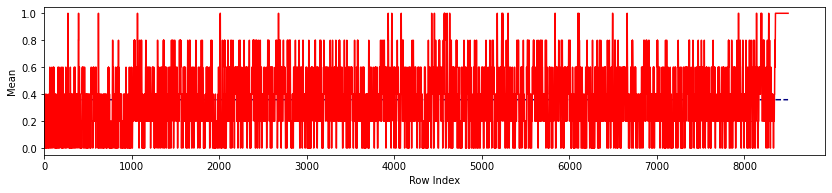

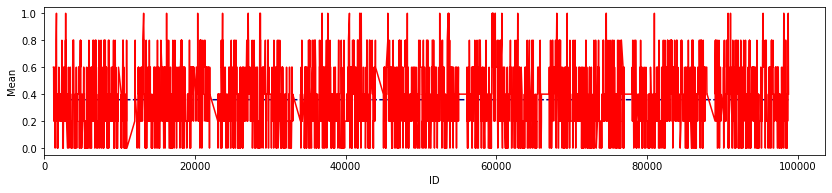

In [62]:
# Plotting - TRAIN
# ROW INDICES

plt.figure(figsize=[14,6])
plt.subplot(211)
x = leak_train.index
y = leak_train.tar_mean
plt.plot(x, y, color='navy', ls='--')

y = leak_train.tar_roll_mean
plt.plot(x, y, color='red')

plt.xlabel('Row Index')
plt.ylabel('Mean')

plt.xlim(left=0)
    
# IDs
plt.figure(figsize=[14, 6])
plt.subplot(212)
x = leak_id_train.id
y = leak_id_train.tar_mean
plt.plot(x, y, color='navy', ls='--')

y = leak_id_train.tar_roll_mean
plt.plot(x, y, color='red')

plt.xlabel('ID')
plt.ylabel('Mean')

plt.xlim(left=0)

In [63]:
# Checking the DEV SET

# Check ROW INDICES
leak_dev = dev_df.copy()
leak_dev['tar_mean'] = leak_dev.label.apply('mean')
leak_dev['tar_roll_mean'] = leak_dev.label.rolling(5).mean()
print(leak_dev.head())
print('-'*50)

# Check IDs
leak_id_dev = dev_df.sort_values(by='id')
leak_id_dev['tar_mean'] = dev_df.label.apply('mean')
leak_id_dev['tar_roll_mean'] = leak_id_dev.label.rolling(5).mean()
print(leak_id_dev.head())
print('-'*50)


      id            img  label  \
0   8291  img/08291.png      1   
1  46971  img/46971.png      1   
2   3745  img/03745.png      1   
3  83745  img/83745.png      1   
4  80243  img/80243.png      1   

                                                text  tar_mean  tar_roll_mean  
0              white people is this a shooting range       0.5            NaN  
1                              bravery at its finest       0.5            NaN  
2  your order comes to $37.50 and your white priv...       0.5            NaN  
3  it is time.. to send these parasites back to t...       0.5            NaN  
4                             mississippi wind chime       0.5            1.0  
--------------------------------------------------
       id            img  label  \
494  1268  img/01268.png      0   
159  1456  img/01456.png      1   
332  1726  img/01726.png      1   
220  1742  img/01742.png      0   
217  1765  img/01765.png      1   

                                                  tex

(0.0, 103592.6)

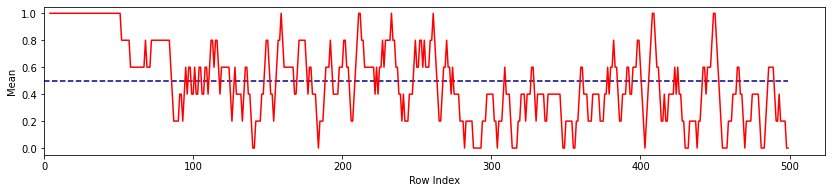

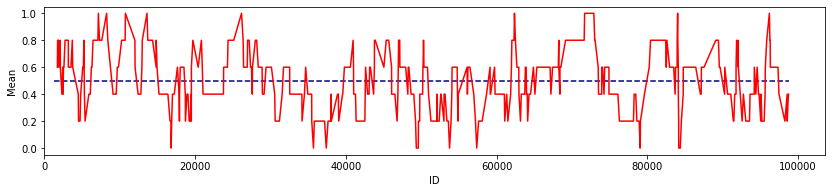

In [64]:
# Plotting - DEV
# ROW INDICES

plt.figure(figsize=[14,6])
plt.subplot(211)
x = leak_dev.index
y = leak_dev.tar_mean
plt.plot(x, y, color='navy', ls='--')

y = leak_dev.tar_roll_mean
plt.plot(x, y, color='red')

plt.xlabel('Row Index')
plt.ylabel('Mean')

plt.xlim(left=0)
    
# IDs
plt.figure(figsize=[14, 6])
plt.subplot(212)
x = leak_id_dev.id
y = leak_id_dev.tar_mean
plt.plot(x, y, color='navy', ls='--')

y = leak_id_dev.tar_roll_mean
plt.plot(x, y, color='red')

plt.xlabel('ID')
plt.ylabel('Mean')

plt.xlim(left=0)

In [65]:
# DEV & TRAIN CONCAT

# Check IDs
trdv_leak_id = pd.concat([train_df, dev_df]).sort_values(by='id')
trdv_leak_id['tar_mean'] = trdv_leak_id.label.apply('mean')
trdv_leak_id['tar_roll_mean'] = trdv_leak_id.label.rolling(5).mean()
print(trdv_leak_id.head())
print('-'*50)

        id            img  label  \
3429  1235  img/01235.png      1   
7329  1236  img/01236.png      0   
6050  1243  img/01243.png      0   
7696  1245  img/01245.png      1   
8339  1247  img/01247.png      1   

                                                   text  tar_mean  \
3429  when you're feeling horny asf but your habibi ...  0.366667   
7329                   meanwhile at the isis strip club  0.366667   
6050  when your human says "who' s a good girl?" and...  0.366667   
7696  and that was the last nativity play my son was...  0.366667   
8339      you can't be racist if there is no other race  0.366667   

      tar_roll_mean  
3429            NaN  
7329            NaN  
6050            NaN  
7696            NaN  
8339            0.6  
--------------------------------------------------


(0.0, 103640.45)

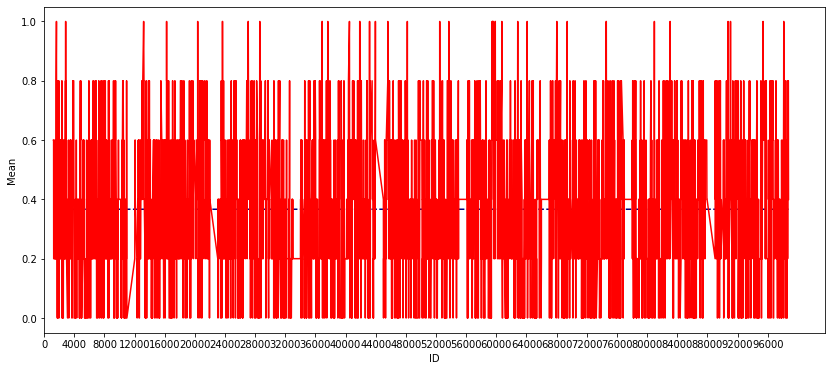

In [66]:
# Plotting - TR DV
    
# IDs
plt.figure(figsize=[14, 6])
x = trdv_leak_id.id
y = trdv_leak_id.tar_mean
plt.plot(x, y, color='navy', ls='--')

y = trdv_leak_id.tar_roll_mean
plt.plot(x, y, color='red')

plt.xlabel('ID')
plt.ylabel('Mean')

plt.xticks(np.arange(0, 100000, step=4000))

plt.xlim(left=0)

- The difference in the two train plots validates that there seem to be nine discrete boxes, let's try group the data into nine boxes! 
- This is due to nine ID boxes.
- The data also consists of exactly 9000 datapoints

In [67]:
len(trdv_leak_id)


# First split until 1025
trdv_leak_id[1020:1030]

print(trdv_leak_id[:1025].mean())

# Second split until 1982
trdv_leak_id[1980:2000]

print(trdv_leak_id[1025:1983].mean())

# Doesn't look like a lot of signal here

id               6049.562927
label               0.358049
tar_mean            0.366667
tar_roll_mean       0.358472
dtype: float64
id               17058.553236
label                0.388309
tar_mean             0.366667
tar_roll_mean        0.387891
dtype: float64


## 4.6 Distribution-based leakage

It might be possible to find the various categories:
"The dev and test set are fully balanced, and are comprised of memes using the following percentages: 40% multimodal hate, 10% unimodal hate, 20% benign textconfounder, 20% benign image confounder, 10% random non-hateful." (Source 1)

Note: 
- Image Confounder == Image is different, text is the same
- Text Confounder == Image is the same, text is different

### 4.6.1 Image Confounder

In [68]:
# Concatenating Train, Dev & Test to search all simultaneously

df_dict = {'train': train_df, 'dev': dev_df, 'test': test_df}

eda_dist = pd.concat([df.assign(identity=key) for key,df in df_dict.items()])

# To save some code lines on visualization
path = '/kaggle/input/fbmdatanopw/data/'
eda_dist['full_path'] = eda_dist['img'].apply(lambda x: path + str(x))

eda_dist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         10000 non-null  int64  
 1   img        10000 non-null  object 
 2   label      9000 non-null   float64
 3   text       10000 non-null  object 
 4   identity   10000 non-null  object 
 5   full_path  10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 546.9+ KB


ImageConfounders have their respective img IDs
False    1.0
dtype: float64
--------------------------------------------------
Duplicate in all vs slf:
False    0.6548
True     0.3452
Name: text_dup, dtype: float64
False    0.7034
True     0.2966
Name: text_dup_slf, dtype: float64
--------------------------------------------------
Duplicate types within different sets:
                     id   img  label  text  full_path  text_dup_slf
identity text_dup                                                  
dev      False      240   240    240   240        240           240
         True       260   260    260   260        260           260
test     False      505   505      0   505        505           505
         True       495   495      0   495        495           495
train    False     5803  5803   5803  5803       5803          5803
         True      2697  2697   2697  2697       2697          2697
                         id   img  label  text  full_path  text_dup
identity text_dup

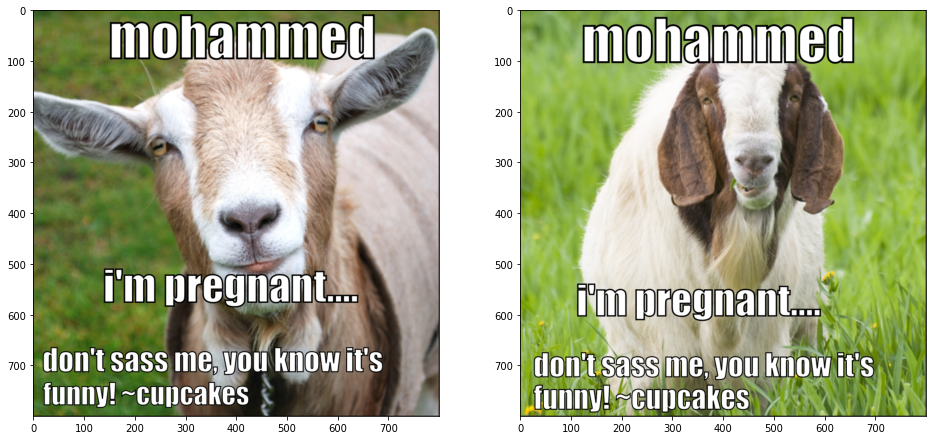

In [69]:
# Differentiating between general duplicates or within a dataset
# Note: Duplicates may be confounders if they are constructed by the organuzers with swapped labels
slf_dups = pd.concat([train_df.duplicated(subset='text', keep=False), dev_df.duplicated(subset='text', keep=False), 
                  test_df.duplicated(subset='text', keep=False)])

#eda_dist['text_start'] = eda_dist.text.str[:15]
eda_dist['text_dup'] = eda_dist.duplicated(subset='text', keep=False)
eda_dist['text_dup_slf'] = slf_dups

print('Image Confounders have their respective img IDs')
print(eda_dist.duplicated(subset='img').value_counts(normalize=True))
print('-'*50)

print('Duplicate in all vs slf:')
print(eda_dist.text_dup.value_counts(normalize=True))
print(eda_dist.text_dup_slf.value_counts(normalize=True))
print('-'*50)


# Text conf within the set itself
print('Duplicate types within different sets:')
print(eda_dist.groupby(['identity', 'text_dup']).count())
print(eda_dist.groupby(['identity', 'text_dup_slf']).count())
print('-'*50)


# Visualizing a inter-set confounder btw test & dev
print('Text Duplicate example within different sets:')
tmp_df = eda_dist.loc[(eda_dist.text_dup == True) & (eda_dist.text_dup_slf == False) & 
             (eda_dist.identity != 'train')]

# Only one duplicated pair - Grab their ids & visualize
print(tmp_df.loc[tmp_df.text.duplicated(keep=False) == True])
img_ids = tmp_df.loc[tmp_df.text.duplicated(keep=False) == True].full_path.values

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(img_ids[0])
imgplot = plt.imshow(img)

plt.subplot(122)
img = mpimg.imread(img_ids[1])
imgplot = plt.imshow(img)



# keep = False, marks both not just the first / last occurence


#print('ImageConfounders have their respective img IDs')
#print(eda_dist.duplicated(subset='img').value_counts(normalize=True))
#print('-'*50)


#print('Confounders in train?')
#print(eda_dist.duplicated(subset='text', keep=False).value_counts(normalize=True))
#print('-'*50)

# Image confounders could be found via dot-products of the images to find similarity

# To further work on this we could implement a calculation of similarity ratio using dot product
# or calculate the Levenshtein distance
# https://www.datacamp.com/community/tutorials/fuzzy-string-python

- This is not a confounder, as both memes are hateful. However, the text is still the same & images are different.

In [70]:
# Most common text duplicates
eda_dist.groupby('text').count().sort_values(by='id', ascending=False)

id  img  label  identity  \
text                                                                           
meanwhile at the isis strip club                    44   44     44        44   
sea monkeys                                         17   17     15        17   
when each letter is a mental disorder               15   15     15        15   
we can kill as many as we want and your stupid ...  15   15     15        15   
a head diaper is required when you have shit fo...  13   13     13        13   
...                                                 ..  ...    ...       ...   
i'm just gonna file that under "who give's a sh...   1    1      1         1   
i'm just gon sit here & mind my business             1    1      1         1   
i'm here to drink whiskey and kill terrorists a...   1    1      1         1   
i'm here as a messenger to give you a message y...   1    1      1         1   
zuckerberg approves                                  1    1      1         1   

                                                    full_path  text_dup  \
text                                                                      
meanwhile at the isis strip club                           44        44   
sea monkeys                                                17        17   
when each letter is a mental disorder                      15        15   
we can kill as many as we want and your stupid ...         15        15   
a head diaper is required when you have shit fo...         13        13   
...                                                       ...       ...   
i'm just gonna file that under "who give's a sh...          1         1   
i'm just gon sit here & mind my business                    1         1   
i'm here to drink whiskey and kill terrorists a...          1         1   
i'm here as a messenger to give you a message y...          1         1   
zuckerberg approves                                         1         1   

                                                    text_dup_slf  
text                                                              
meanwhile at the isis strip club                              44  
sea monkeys                                                   17  
when each letter is a mental disorder                         15  
we can kill as many as we want and your stupid ...            15  
a head diaper is required when you have shit fo...            13  
...                                                          ...  
i'm just gonna file that under "who give's a sh...             1  
i'm just gon sit here & mind my business                       1  
i'm here to drink whiskey and kill terrorists a...             1  
i'm here as a messenger to give you a message y...             1  
zuckerberg approves                                            1  

[8045 rows x 7 columns]

         id            img  label         text identity  \
1140  82940  img/82940.png    0.0  sea monkeys    train   
1438  16298  img/16298.png    0.0  sea monkeys    train   
1545  75209  img/75209.png    1.0  sea monkeys    train   
1853  89123  img/89123.png    1.0  sea monkeys    train   
2284   1578  img/01578.png    1.0  sea monkeys    train   
2806   2793  img/02793.png    0.0  sea monkeys    train   
3217  90175  img/90175.png    0.0  sea monkeys    train   
4031  10436  img/10436.png    1.0  sea monkeys    train   
4056  60739  img/60739.png    0.0  sea monkeys    train   
5526  70864  img/70864.png    1.0  sea monkeys    train   
5886  83056  img/83056.png    1.0  sea monkeys    train   
6957  75231  img/75231.png    1.0  sea monkeys    train   
7745  94610  img/94610.png    0.0  sea monkeys    train   
8010  52948  img/52948.png    0.0  sea monkeys    train   
8265  38057  img/38057.png    0.0  sea monkeys    train   
786   79531  img/79531.png    NaN  sea monkeys     test 

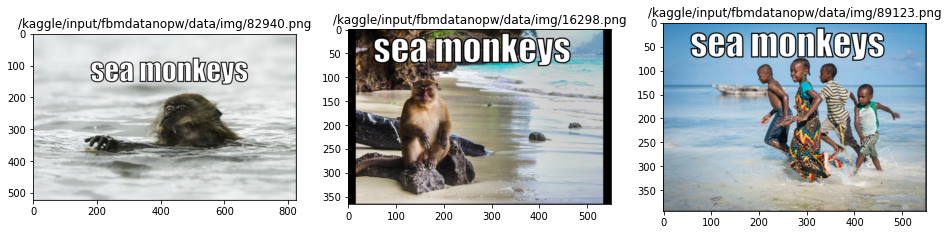

In [72]:
# Visualizing some of the most common texts to check for mistakes


img_ps = eda_dist.loc[(eda_dist.text == 'sea monkeys')].full_path.values
print(eda_dist.loc[(eda_dist.text == 'sea monkeys')])
print('-'*50)

fig = plt.figure(figsize=[16,12])

plt.subplot(131)
img = mpimg.imread(img_ps[0])
plt.title(img_ps[0])
imgplot = plt.imshow(img)

plt.subplot(132)
img = mpimg.imread(img_ps[1])
plt.title(img_ps[1])
imgplot = plt.imshow(img)

plt.subplot(133)
img = mpimg.imread(img_ps[3])
plt.title(img_ps[3])
imgplot = plt.imshow(img)

print('sea monkeys seem to be all correctly labelled - But ~8/17 are complete duplicates \
       Also important to note that some are in text & some in train.')


### 4.6.2 Text Confounder

In [73]:
# Differentiating between 100% duplicates & Confounders
# Good overview on image hash functions: 
# https://content-blockchain.org/research/testing-different-image-hash-functions/

def hash_func(img_path):
    
    # Assumption: Full Duplicates have the exact same pixel values
    
    img = Image.open(img_path)
    img = np.asarray(img, dtype="int32")
    
    # Though it is easier to just define a good crude hash & then find complete duplicates via same text
    # there are also images with different shapes - perceptual hash is robust to this 
    # Using phash from imagehash
    
    hash_v = imagehash.phash(Image.open(img_path))
    
    return hash_v
    
def hash_func_crude(img_path):
    
    # Building a unique duplicate identifier
    # Assumptions: Confounders have the same shape & the some diagonal pixelfrom upper right corner is the same
    
    img = Image.open(img_path)
    img = np.asarray(img, dtype="int32")
    
    # Going down the diagonal from ri up corner until no b/w/g value 
    row_val = 0
    col_val = -1
    try:
        while((not(255 > img[row_val, col_val, 0] > 1)) 
              or (not(img[row_val, col_val, 0] != img[row_val, col_val, 1] != img[row_val, col_val, 2]))):

            # In words: While it is true that the value is not btw 1 & 255 or the rgb values are not all different, keep going
            row_val += 1
            col_val -= 1
    
    except:
        row_val = 0
        col_val = -1
        
        while(not(255 > img[row_val, col_val, 0] > 1)): 
            row_val += 1
            col_val -= 1
    
    hash_v = str(img.shape[0]) + str(img.shape[1]) + str(img[row_val, col_val, 0]) + str(img[row_val, col_val, 1]) + str(img[row_val, col_val, 2]) 
    
    return hash_v


eda_dist['hash'] = eda_dist['full_path'].apply(lambda x: hash_func(x))
eda_dist['hash_cr'] = eda_dist['full_path'].apply(lambda x: hash_func_crude(x))

eda_dist.head()

id            img  label  \
0  42953  img/42953.png    0.0   
1  23058  img/23058.png    0.0   
2  13894  img/13894.png    0.0   
3  37408  img/37408.png    0.0   
4  82403  img/82403.png    0.0   

                                                text identity  \
0   its their character not their color that matters    train   
1  don't be afraid to love again everyone is not ...    train   
2                           putting bows on your pet    train   
3  i love everything and everybody! except for sq...    train   
4  everybody loves chocolate chip cookies, even h...    train   

                                      full_path  text_dup  text_dup_slf  \
0  /kaggle/input/fbmdatanopw/data/img/42953.png     False         False   
1  /kaggle/input/fbmdatanopw/data/img/23058.png     False         False   
2  /kaggle/input/fbmdatanopw/data/img/13894.png      True          True   
3  /kaggle/input/fbmdatanopw/data/img/37408.png     False         False   
4  /kaggle/input/fbmdatanopw/data/img/82403.png     False         False   

               hash          hash_cr  
0  96ee851ba33d9314     400265424334  
1  eab5465a1992d6c9  533800230234237  
2  b41e79c6c9070fc3     800558948999  
3  b0f2b7480dcde427  800693250254255  
4  fffb8022e469c119  416550222222222

In [74]:
# Getting a list of all hashes from most to least common
hash_list = eda_dist.hash.value_counts().index
hash_cr_list = eda_dist.hash_cr.value_counts().index

Index([abff8c81d38cc03a, abff8c81538ce03a, abff8c81538cc0ba, ef0f90d25da5b068,
       abff8c80d38ce03a, abff8c81d38cc09a, e3c59e9949326764, c83ef0e566b4c526,
       9562a8c60afbc6ba, 9e69743aa1967986,
       ...
       e58c1a516b51b5ce, e969199ab46a4b9a, c5cd303cd7f03ad0, 9da7c39cb506638a,
       e64c4906f637a0ed, a4d0d258ced39b27, 98eee651c88907dd, a6d9b1261fca82d9,
       be91919ce86e494e, a4904fdb9b64139b],
      dtype='object', length=9830)
--------------------------------------------------
         id            img  label  \
86    90583  img/90583.png    1.0   
3638  51462  img/51462.png    1.0   
4006  54981  img/54981.png    1.0   
5394  75291  img/75291.png    0.0   
482   37692  img/37692.png    0.0   

                                                   text identity  \
86    we can kill as many as we want and your stupid...    train   
3638  we can kill as many as we want and your stupid...    train   
4006  we can kill as many as we want and your stupid...    train   
5394 

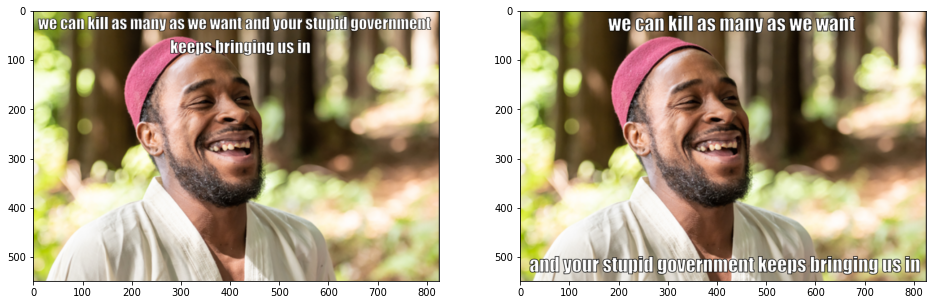

In [75]:
# HASH_CR vs HASH

# Change index to visualize different hashes
img_ps = eda_dist.loc[eda_dist.hash == hash_list[3]].full_path.values
print(hash_list)
print('-'*50)

print(eda_dist.loc[eda_dist.hash == hash_list[3]])
print('-'*50)

print(len(img_ps))
print('-'*50)

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(img_ps[0])
imgplot = plt.imshow(img)

plt.subplot(122)
img = mpimg.imread(img_ps[3])
imgplot = plt.imshow(img)

# PHash catches different shapes which happens quite a lot

        id            img  label                           text identity  \
293  73605  img/73605.png    0.0           no matter what smile      dev   
441  47016  img/47016.png    1.0  last summer camp was so "lit"      dev   

                                        full_path  text_dup  text_dup_slf  \
293  /kaggle/input/fbmdatanopw/data/img/73605.png     False         False   
441  /kaggle/input/fbmdatanopw/data/img/47016.png      True          True   

                 hash       hash_cr  
293  9d64d6bc9665cc18  400284573830  
441  cd7564969ce38c4a  400284573830  
--------------------------------------------------
2
--------------------------------------------------


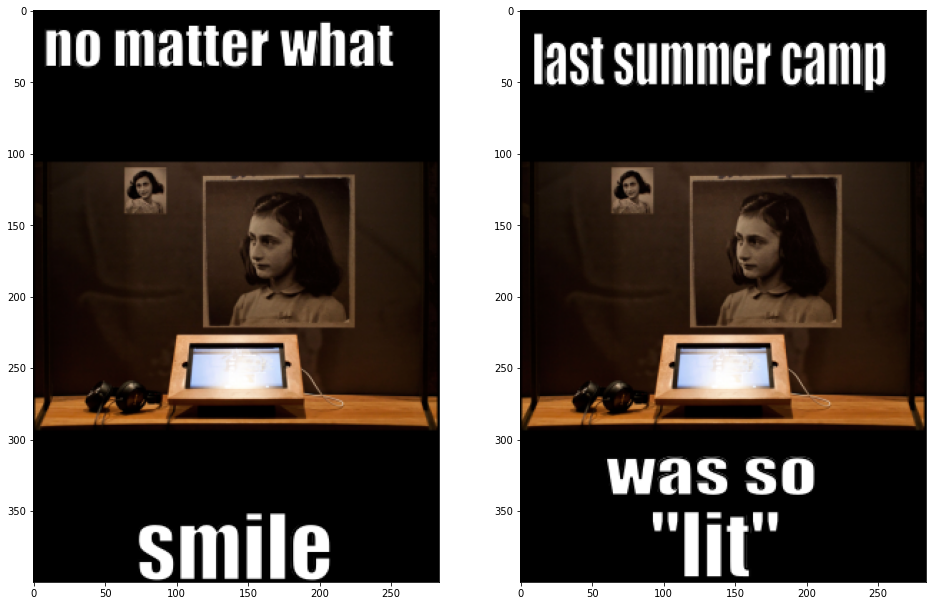

In [76]:
# Change index to visualize different hashes
img_ps = eda_dist.loc[eda_dist.hash_cr == hash_cr_list[1000]].full_path.values

print(eda_dist.loc[eda_dist.hash_cr == hash_cr_list[1000]])
print('-'*50)

print(len(img_ps))
print('-'*50)

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(img_ps[0])
imgplot = plt.imshow(img)

plt.subplot(122)
img = mpimg.imread(img_ps[1])
imgplot = plt.imshow(img)

# Crude catches pictures with big & small text

Huge differences in distribution?
False    0.9698
True     0.0302
Name: img_dup0, dtype: float64
False    0.6378
True     0.3622
Name: img_dup1, dtype: float64
--------------------------------------------------
Index(['399277171717', '400300238225180', '3665502825', '359550192200213',
       '799555343434', '80052599100118', '366550534', '400266725536',
       '533800321', '533800645',
       ...
       '800646439', '4002664276115', '547825333', '400323151336',
       '516550102144200', '800533515039', '549825355674', '800533193655',
       '549825423731', '3665508993110'],
      dtype='object', length=1445)
--------------------------------------------------
         id            img  label  \
242   49601  img/49601.png    0.0   
920   63702  img/63702.png    0.0   
1408  61289  img/61289.png    0.0   
5452  90614  img/90614.png    1.0   
6297  82697  img/82697.png    1.0   
7834  56082  img/56082.png    0.0   

                                                   text identity  \
242  

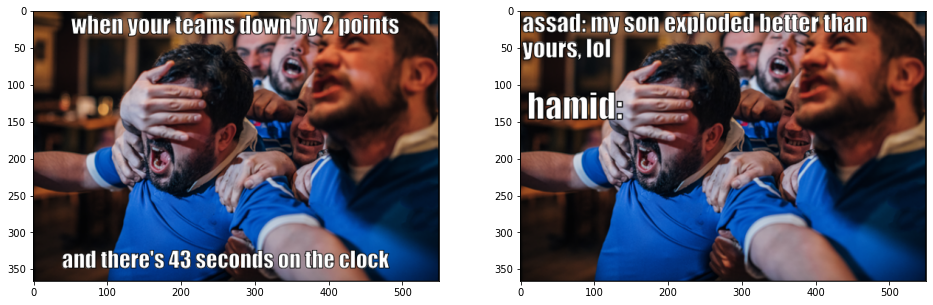

In [77]:
# Comparing 
eda_dist['img_dup0'] = eda_dist.duplicated(subset='hash', keep=False)
eda_dist['img_dup1'] = eda_dist.duplicated(subset='hash_cr', keep=False)

print('Huge differences in distribution?')
print(eda_dist.img_dup0.value_counts(normalize=True))
print(eda_dist.img_dup1.value_counts(normalize=True))
print('-'*50)


# Visualizing confs only in crude not in normal
cr_only = eda_dist.loc[(eda_dist.img_dup0 == False) & 
                       (eda_dist.img_dup1 == True)].sort_values(by='hash_cr').hash_cr.value_counts().index

img_ps = eda_dist.loc[eda_dist.hash_cr == cr_only[20]].full_path.values


print(cr_only)
print('-'*50)

print(eda_dist.loc[eda_dist.hash_cr == cr_only[20]])
print('-'*50)

print(len(img_ps))
print('-'*50)

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(img_ps[2])
imgplot = plt.imshow(img)

plt.subplot(122)
img = mpimg.imread(img_ps[3])
imgplot = plt.imshow(img)

# Crude catches quite a lot of valuable examples

In [78]:
eda_dist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            10000 non-null  int64  
 1   img           10000 non-null  object 
 2   label         9000 non-null   float64
 3   text          10000 non-null  object 
 4   identity      10000 non-null  object 
 5   full_path     10000 non-null  object 
 6   text_dup      10000 non-null  bool   
 7   text_dup_slf  10000 non-null  bool   
 8   hash          10000 non-null  object 
 9   hash_cr       10000 non-null  object 
 10  img_dup0      10000 non-null  bool   
 11  img_dup1      10000 non-null  bool   
dtypes: bool(4), float64(1), int64(1), object(6)
memory usage: 742.2+ KB


### 4.6.3 Triple Confounder

        id            img  label                                        text  \
428  40618  img/40618.png    0.0  when your company valuation hits 1 billion   

    identity                                     full_path  text_dup  \
428      dev  /kaggle/input/fbmdatanopw/data/img/40618.png     False   

     text_dup_slf              hash          hash_cr  img_dup0  img_dup1  
428         False  b2e39cc93c4c8f1a  547825250247244     False      True  
--------------------------------------------------
        id            img  label  \
423  97305  img/97305.png    1.0   

                                                  text identity  \
423  when your wife just died giving birth to your ...      dev   

                                        full_path  text_dup  text_dup_slf  \
423  /kaggle/input/fbmdatanopw/data/img/97305.png      True          True   

                 hash          hash_cr  img_dup0  img_dup1  
423  b2679cc9382f8e1a  547825250247244     False      True  
--------

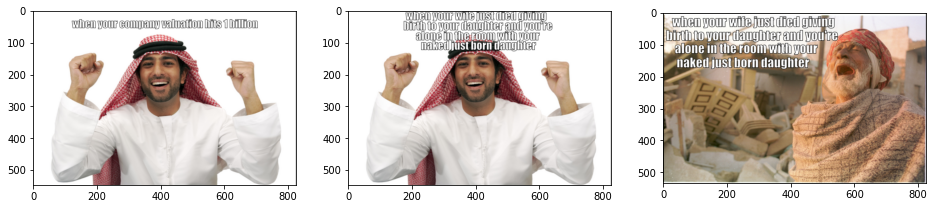

In [79]:
# Triple confounder : 40618 & 97305

print(eda_dist.loc[eda_dist.id == 40618])
print('-'*50)
print(eda_dist.loc[eda_dist.id == 97305])
print('-'*50)
print(eda_dist.loc[eda_dist.id == 98720])
print('-'*50)
# Found via dev_df.loc[dev_df.text == (dev_df.loc[dev_df.id == 97305].text.values[0])]

conf_one = '/kaggle/input/fbmdatanopw/data/img/40618.png'
conf_two = '/kaggle/input/fbmdatanopw/data/img/97305.png'
conf_three = '/kaggle/input/fbmdatanopw/data/img/98720.png'

fig = plt.figure(figsize=[16,12])

plt.subplot(131)
img = mpimg.imread(conf_one)
imgplot = plt.imshow(img)

plt.subplot(132)
img = mpimg.imread(conf_two)
imgplot = plt.imshow(img)

plt.subplot(133)
img = mpimg.imread(conf_three)
imgplot = plt.imshow(img)

# The latter two images even seem slightly different - & Why did they not get the same torch.sum?
# This could also serve as a great example to calc further similarity measures

#1116369.25 & 751800.1875

In [80]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        
        return distance[row][col]
    
    
levenshtein_ratio_and_distance(eda_dist.loc[eda_dist.id == 97305].text.values[0], eda_dist.loc[eda_dist.id == 98720].text.values[0])

0

## 4.7 Misclassified & Duplicated

*Meanwhile at the ISIS Strip Club....*

Plan: There are two types of misclassified memes:
1. Misclassified duplicate - There exists a duplicate of the same meme with a different label
    - Attributes:
        - Text may slightly vary (e.g. ID 52714) due to e.g. a meaningless word attached
        - Image is generally the same, but white text may vary strongly in size (-> Hash_cr & hash must be used)
    - 1/2 Plan:
        - Organize images into hash_cr/hash buckets (~4000 buckets)
        - Organize buckets into buckets with label discrepancy (i.e. mean label is not 0 or 1) (~900 buckets)
        - Discard buckets with big levenshtein distance (~47 buckets)
        - Finally go through remainder buckets & either discard all or keep some
        
    - 2/2 Plan:
        - Finetune with PHash: Follow same procedure w/ Phash on the presorted dataset
2. Misclassified in itself - The meme itself has been wrongly classified
    - Rely fully on ids posted on the forums (~100)

### 4.7.1 Crude dupplicates & misclassified duplicates - Hash_cr

In [81]:
g_labs = pd.Series(eda_dist.groupby(['hash_cr']).apply(lambda x: x['label'].mean()), name='label_avg')
g_counts = pd.Series(eda_dist.groupby(['hash_cr']).count().id, name='counts')

groups = pd.concat([g_labs, g_counts], axis=1) #~4000

groups = groups.loc[(groups.label_avg != 0) & (groups.label_avg != 1) & (groups.label_avg.notnull())] #~900

keep_ids = set()

for p in groups.index.values:
    
    txts = eda_dist.loc[eda_dist.hash_cr == p].text.values

    for i in range(0, len(txts)):
        for j in range(i+1, len(txts)):
            
            ratio = levenshtein_ratio_and_distance(txts[i], txts[j], ratio_calc = True)
            
            # Based on reading through some texts 0.95 seems like an empirically good threshold to only keep mistakes
            # & not purposeful confounders
            if ratio > 0.95:

                keep_ids.add(p)

groups = groups[groups.index.isin(keep_ids)]
groups.info()        

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, 365550242241240 to 800800232118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   label_avg  47 non-null     float64
 1   counts     47 non-null     int64  
dtypes: float64(1), int64(1)
memory usage: 1.1+ KB


[ 1.  0.  1.  1.  0.  0.  0. nan nan]
[53607 63524 52714 47308 19573 16340 28597 75039 41527]
["it's racist to call me a goat humper even though i hump goats"
 "islam is a religion of peace if you don't agree then you're ignorant"
 'class! class! listen! daylight savings ends today you must move your clock bombs forward one hour'
 'show me your bare naked ankles you dirty whore'
 'when you have a screaming contest at the protest'
 'you call me a goat fucker that is racist'
 'class! class! listen! daylight savings ends today you must move your clock forward one hour'
 'rape helping them have sex for generations'
 'we protest for our rights !']


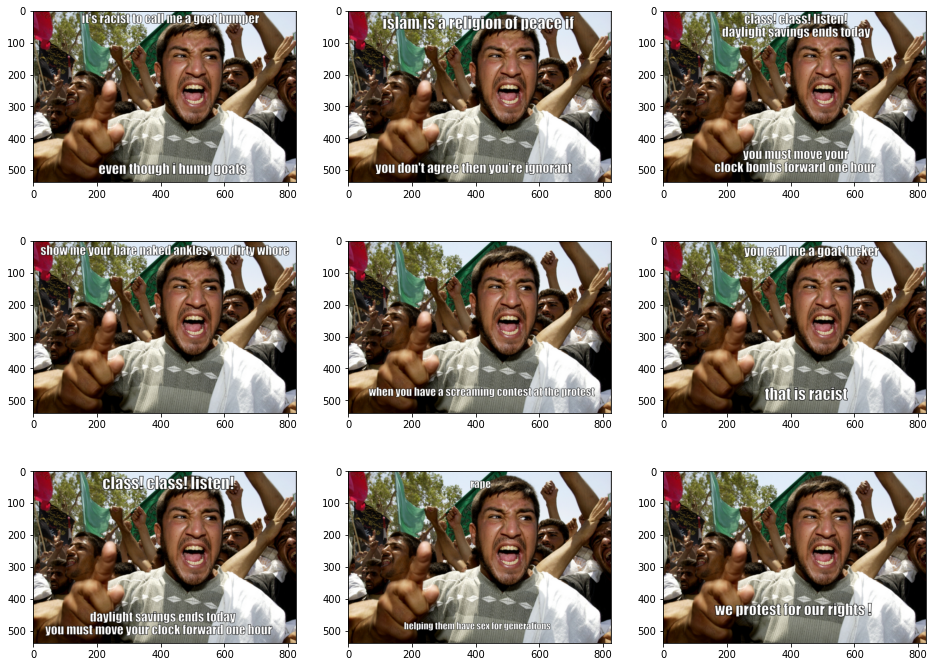

In [82]:
buckets = groups.index.values

buckets = buckets[19:]

for b in buckets:
    
    paths = eda_dist.loc[eda_dist.hash_cr == b].full_path.values
    labels = eda_dist.loc[eda_dist.hash_cr == b].label.values
    ids = eda_dist.loc[eda_dist.hash_cr == b].id.values
    txts = eda_dist.loc[eda_dist.hash_cr == b].text.values
    
    print(labels)
    print(ids)
    print(txts)
    
    fig = plt.figure(figsize=[16,12])
    
    for i in range(len(paths)):
        a = fig.add_subplot(331 + i)
        img = mpimg.imread(paths[i+0])
        imgplot = plt.imshow(img)
    
    break
    
# -> Also implement Levenshtein distance for pairs

# We differentiate btw:
# Exact dups (they should be removed as no additional value to the dataset)
# Dups, but not exact - we keep them as augmentation 
# DupDiff - Dups with different Labels
# Confounders (Our algo failed here - we obv leave them in)

# Note: Everywhere, where I say remove both, I'm going the save route as I just don't know
# We might want to alter this lateron and see if it has an impact on results
# For imgs with remove only - we can also just inverse the label of that img & keep the duplicate

# Iterating through all 47 buckets and noting mistakes:
# 0: Dups
# 1: DupDiff - remove both: 95780 17835
# 2: Dups
# 3: DupDiff - Remove only 7693 (0)
# 4: Exact Dup - 64207
# 5: Dups
# 6: Exact Dup - 75209
# 7: Dups 3/6 but with different type setting; okay
# 8: Dups but diff typesetting
# 9: Dups Hitler memes; Seem okay -- difficult meme with juice vs jews - BERT must understand jews
# 10: Dups Hitler Seems okay - i dont get everything
# 11: Dups - vitiligo jokes: seems okay
# 12: Confounder - very tough
# 13: DupDiff - remove both 94532 17294
# 14: Dups
# 15: Exact Dup - 45601
# 16: DupDiff - remove both 57348 17843
# 17: DupDiff - remove 75984
# 18: Dups
# 19: Confounder - clock vs clock bombs
# 20: DupDiff - remove both 52904 67130
# 21: Dups
# 22: Dups
# 23: Dups
# 24: DupDiff - remove both 98425 25493
# 25: DupDiff - remove 75291 + 4 Dups -- remove some if ever we apply data augmenation ourselves
# 26: DupDiff - remove 9364
# 27: DupDiff - remove 61482
# 28: Dups; Hitler - Great noise with writing mistakes
# 29: DupDiff - remove 36789
# 30: Dups
# 31: DupDiff - remove both 62198, 48276
# 32: Dups
# 33: DupDiff - remove both 48630 80954
# 34: DupDiff - remove 83415
# 35: 3 Dups
# 36: DupDiff - remove both 4356 67129
# 37: Dups
# 38: DupDiff - remove 72834
# 39: DupDiff, 6 Dups - remove 13470 + for Dups: 9138, 23501, 82539 
# 40: DupDiff - remove all memes w/ text 'i only wear silk panties..'
# 41: DupDiff - remove all 53147  2763 36190
# 42: DupDiff - remove both 19705 96471 (naked corpse; good one tho)
# 43: DupDiff - remove both 62435 65240
# 44: DupDiff - remove all memes w/ text meanwhile at the isis strip club (check other isis memes first)
# 45: DupDiff - remove 78294; congress muslims
# 46: 3 Dups - remove 41362　－Other two have good noise thanks to text

In [83]:
# Constructing two lists for removal

silk_list = eda_dist.loc[eda_dist.text.str.contains('only wear silk panties')].id.values.tolist()
isis_list = eda_dist.loc[eda_dist.text.str.contains('at the isis strip club')].id.values.tolist()

dupdiffs = [95780, 17835, 7693, 94532, 17294, 57348, 17843, 75984, 52904, 67130, 98425, 25493, 75291, 9364, 61482, 36789, 
            62198, 48276, 48630, 80954, 83415, 4356, 67129, 72834, 13470, 53147, 2763, 36190, 19705, 96471, 62435, 65240, 
            78294]


dupsexact = [64207, 75209, 45601]

dups = [9138, 23501, 82539, 41362]

# Creating a version without exact dups & dupdiffs

# Dropping w/o any augmentation on our own - silk, isis, dupdiff, dupsexact

drop0 = silk_list + isis_list + dupdiffs + dupsexact

# Dropping w/ augmentation on our own += dups

#eda_dist0 = eda_dist.drop(labels=drop_wo, index=0, )

eda_dist0 = eda_dist[~eda_dist['id'].isin(drop0)]
eda_dist0.info()
print('-'*50)
print('Important to note that no value from test nor dev got deleted - Hence an indication that both are fairly clean')
print()
print(eda_dist0.loc[eda_dist0.identity == 'dev'].info())
print(eda_dist0.loc[eda_dist0.identity == 'test'].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9908 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9908 non-null   int64  
 1   img           9908 non-null   object 
 2   label         8908 non-null   float64
 3   text          9908 non-null   object 
 4   identity      9908 non-null   object 
 5   full_path     9908 non-null   object 
 6   text_dup      9908 non-null   bool   
 7   text_dup_slf  9908 non-null   bool   
 8   hash          9908 non-null   object 
 9   hash_cr       9908 non-null   object 
 10  img_dup0      9908 non-null   bool   
 11  img_dup1      9908 non-null   bool   
dtypes: bool(4), float64(1), int64(1), object(6)
memory usage: 735.4+ KB
--------------------------------------------------
Important to note that no value from test nor dev got deleted - Hence an indication that both are fairly clean

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 en

- Removed lots of duplicates for the models
- The images above show an example of an image appearing >9 times in the dataset

### 4.7.2 Finetuning w/ phash

In [84]:
# 1. Misclassified duplicate - Hash - 2/2 - Continuing with eda_dist0

# Group by not working here, hence we need to go with value counts

# Using reset_index but keeping the old index to get a df
hash_df = eda_dist0.hash.value_counts().reset_index(name="counter")
hash_df = hash_df.loc[hash_df['counter'] > 1]

keep_ids = set()

for h in hash_df['index'].astype(str).values:
    
    mean = eda_dist0.loc[eda_dist0.hash.astype(str) == h].label.mean()
    
    if not(1 > mean > 0):
        continue
    
    txts = eda_dist0.loc[eda_dist0.hash.astype(str) == h].text.values
    
    for i in range(0, len(txts)):
        for j in range(i+1, len(txts)):
            
            ratio = levenshtein_ratio_and_distance(txts[i], txts[j], ratio_calc = True)
            
            if ratio > 0.95:
                keep_ids.add(h)

hash_df = hash_df[hash_df['index'].astype(str).isin(keep_ids)]
hash_df.info()        

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3 entries, 0 to 34
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    3 non-null      object
 1   counter  3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 72.0+ bytes


[1. 1. 1. 0.]
[90583 51462 54981 37692]
['we can kill as many as we want and your stupid government keeps bringing us in'
 'we can kill as many as we want and your stupid government keeps bringing us in'
 'we can kill as many as we want and your stupid government keeps bringing us in'
 '"islam is a religion of peace stop criticizing my religion"']


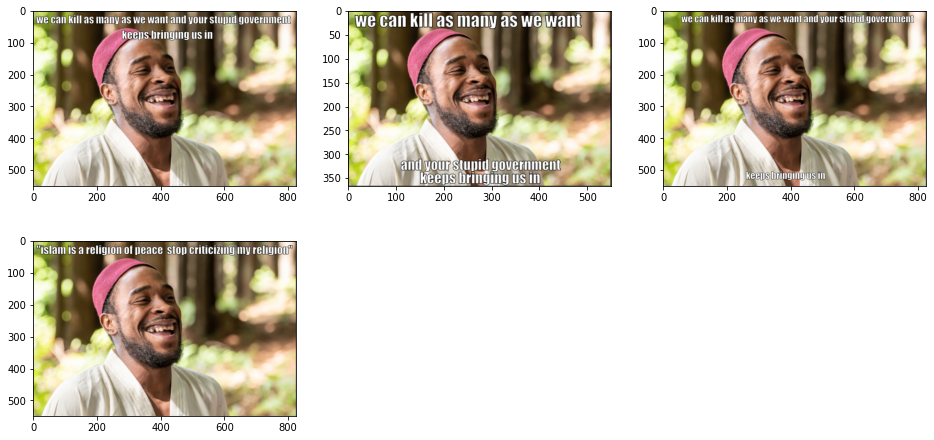

In [85]:
buckets = hash_df['index'].astype(str).values

buckets = buckets[0:]

for b in buckets:
    
    paths = eda_dist0.loc[eda_dist0.hash.astype(str) == b].full_path.values
    labels = eda_dist0.loc[eda_dist0.hash.astype(str) == b].label.values
    ids = eda_dist0.loc[eda_dist0.hash.astype(str) == b].id.values
    txts = eda_dist0.loc[eda_dist0.hash.astype(str) == b].text.values
    
    print(labels)
    print(ids)
    print(txts)
    
    fig = plt.figure(figsize=[16,12])
    
    for i in range(len(paths)):
        a = fig.add_subplot(331 + i)
        img = mpimg.imread(paths[i+0])
        imgplot = plt.imshow(img)
    
    break
    
# 0: 3 Dups w/ diff shapes
# 1: DupDiff - remove both 18275 21589
# 2: DupDiff - remove both 80765 59062

In [100]:
drop1 = [18275, 21589, 80765, 59062]


eda_dist0 = eda_dist0[~eda_dist0['id'].isin(drop1)]
eda_dist0.info()
print('-'*50)
print('Validation & Test set both are fairly clean')
print()
print(eda_dist0.loc[eda_dist0.identity == 'dev'].info())
print(eda_dist0.loc[eda_dist0.identity == 'test'].info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9903 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9903 non-null   int64  
 1   img           9903 non-null   object 
 2   label         8903 non-null   float64
 3   text          9903 non-null   object 
 4   identity      9903 non-null   object 
 5   full_path     9903 non-null   object 
 6   text_dup      9903 non-null   bool   
 7   text_dup_slf  9903 non-null   bool   
 8   hash          9903 non-null   object 
 9   hash_cr       9903 non-null   object 
 10  img_dup0      9903 non-null   bool   
 11  img_dup1      9903 non-null   bool   
dtypes: bool(4), float64(1), int64(1), object(6)
memory usage: 735.0+ KB
--------------------------------------------------
Validation & Test set both are fairly clean

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column       

- Important to note that no value from test nor dev got deleted - Hence an indication that both are fairly clean

### 4.7.3 Additional Duplicates - Exactly the same duplicates, Misclassified Duplicates

         id            img  label  \
2818  43679  img/43679.png    0.0   
2880  14590  img/14590.png    0.0   
3707  59601  img/59601.png    1.0   
5143  76341  img/76341.png    0.0   
6929   4718  img/04718.png    0.0   

                                                   text identity  \
2818            fifty shades of goat an isis love story    train   
2880            fifty shades of goat an isis love story    train   
3707            fifty shades of goat an isis love story    train   
5143                 please kill isis # goatlivesmatter    train   
6929  isis you mean them goat fuckers that don't lik...    train   

                                         full_path  text_dup  text_dup_slf  \
2818  /kaggle/input/fbmdatanopw/data/img/43679.png      True          True   
2880  /kaggle/input/fbmdatanopw/data/img/14590.png      True          True   
3707  /kaggle/input/fbmdatanopw/data/img/59601.png      True          True   
5143  /kaggle/input/fbmdatanopw/data/img/76341.png     F

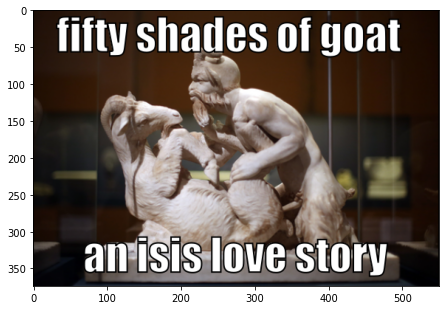

In [87]:
# ISIS & Goats

# It semes that it is okay to insult ISIS
# But it is not okay if it involves a picture of a concrete person
# If that analysis is correct, let us remove 14590

print(eda_dist0.loc[eda_dist0.text.str.contains('isis') & (eda_dist0.text.str.contains('goat'))])

paths = eda_dist0.loc[eda_dist0.text.str.contains('isis') & (eda_dist0.text.str.contains('goat'))].full_path.values

path0 = paths[0]

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(path0)
imgplot = plt.imshow(img)

In [88]:
drop2 = [14590]

eda_dist0 = eda_dist0[~eda_dist0['id'].isin(drop2)]
eda_dist0.info()
print('-'*50)
print('Important to note that no value from test nor dev got deleted - Hence an indication that both are fairly clean')
print()
print(eda_dist0.loc[eda_dist0.identity == 'dev'].info())
print(eda_dist0.loc[eda_dist0.identity == 'test'].info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9903 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9903 non-null   int64  
 1   img           9903 non-null   object 
 2   label         8903 non-null   float64
 3   text          9903 non-null   object 
 4   identity      9903 non-null   object 
 5   full_path     9903 non-null   object 
 6   text_dup      9903 non-null   bool   
 7   text_dup_slf  9903 non-null   bool   
 8   hash          9903 non-null   object 
 9   hash_cr       9903 non-null   object 
 10  img_dup0      9903 non-null   bool   
 11  img_dup1      9903 non-null   bool   
dtypes: bool(4), float64(1), int64(1), object(6)
memory usage: 735.0+ KB
--------------------------------------------------
Important to note that no value from test nor dev got deleted - Hence an indication that both are fairly clean

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 en

### 4.7.4 Misclassified by itself

In [89]:
forum_ids = [1258, 1598, 1823, 2358, 2471, 2475, 2519, 2647, 2793, 3528, 3794, 4356, 4926, 5164, 5261, 5329, 5421, 5479, 
             6194, 6319, 6534, 6579, 6714, 6985, 7523, 8126, 8439, 8546, 8719, 9156, 9364, 9547, 9587, 10259, 10583, 
             10732, 10943, 12483, 12957, 13486, 14695, 14830, 15493, 16280, 17235, 19430, 23615, 23957, 27056, 27134, 
             27685, 28405, 30489, 31429, 32470, 32490, 34586, 34985, 35402, 36048, 36081, 37265, 37601, 42065, 43521, 
             43826, 46712, 54891, 56249, 56423, 59678, 61204, 72936, 83150, 92405, 92408, 92413, 93057, 90471, 20568, 
             84269, 91405, 95684, 27351]

misc_df = train_df[train_df['id'].isin(forum_ids)].copy()
print(misc_df.tail())
misc_df.loc[:, 'label'].replace({0:1, 1:0}, inplace=True) #misc_df.loc[:, 'label'] =
print(misc_df.tail())

         id            img  label  \
8051  10732  img/10732.png      0   
8138  93057  img/93057.png      1   
8143  56423  img/56423.png      1   
8189  37265  img/37265.png      1   
8361   5261  img/05261.png      1   

                                                   text  
8051  look dad im doing it you did it tyrone! you st...  
8138  how men who ride crotch rockets check on their...  
8143           whoever photoshopped this is a huge jerk  
8189       mission: get out of bed status: close enough  
8361  i'm deporting all mexicans!!! except the ones ...  
         id            img  label  \
8051  10732  img/10732.png      1   
8138  93057  img/93057.png      0   
8143  56423  img/56423.png      0   
8189  37265  img/37265.png      0   
8361   5261  img/05261.png      0   

                                                   text  
8051  look dad im doing it you did it tyrone! you st...  
8138  how men who ride crotch rockets check on their...  
8143           whoever photoshop

[]
[]
[]
[0.]
[84269]
['just ordered the new anne frank puzzle']
[0.]
[91405]
['wears rag on her head so her brother husband doesnt want to molest her']
[0.]
[95684]
["i'm not transphobic i just don't like 'em"]
[0.]
[27351]
['at least hitler could use an oven']


<Figure size 1152x864 with 0 Axes>

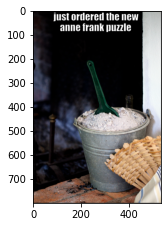

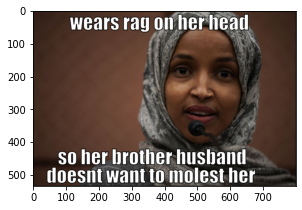

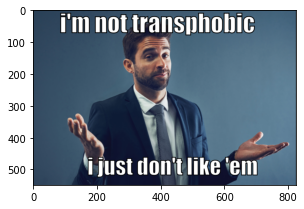

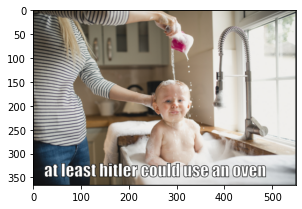

In [101]:
forum_ids = [1258, 1598, 1823, 2358, 2471, 2475, 2519, 2647, 2793, 3528, 3794, 4356, 4926, 5164, 5261, 5329, 5421, 5479, 
             6194, 6319, 6534, 6579, 6714, 6985, 7523, 8126, 8439, 8546, 8719, 9156, 9364, 9547, 9587, 10259, 10583, 
             10732, 10943, 12483, 12957, 13486, 14695, 14830, 15493, 16280, 17235, 19430, 23615, 23957, 27056, 27134, 
             27685, 28405, 30489, 31429, 32470, 32490, 34586, 34985, 35402, 36048, 36081, 37265, 37601, 42065, 43521, 
             43826, 46712, 54891, 56249, 56423, 59678, 61204, 72936, 83150, 92405, 92408, 92413, 93057, 90471, 20568, 
             84269, 91405, 95684, 27351]


# Note 91405 is in the dev set; all others train

add_ids = [34876]

# Adjust as necessary
viz_ids = forum_ids[-5:]

for i in viz_ids:
    
    paths = eda_dist0.loc[eda_dist0.id == i].full_path.values
    labels = eda_dist0.loc[eda_dist0.id == i].label.values
    ids = eda_dist0.loc[eda_dist0.id == i].id.values
    txts = eda_dist0.loc[eda_dist0.id == i].text.values
    
    print(labels)
    print(ids)
    print(txts)
    
    fig = plt.figure(figsize=[16,12])
    
    for j in range(len(paths)):
        a = fig.add_subplot(331 + j)
        img = mpimg.imread(paths[j])
        imgplot = plt.imshow(img)

In [91]:
# Removing all of the ids above

drop3 = forum_ids + add_ids

print('Lengths before', len(drop3), len(eda_dist0))

eda_dist1 = eda_dist0[~eda_dist0['id'].isin(drop3)]
eda_dist1.info()
print('-'*50)
print('Including some dev ids')
print()
print(eda_dist1.loc[eda_dist1.identity == 'dev'].info())
print(eda_dist1.loc[eda_dist1.identity == 'test'].info())

Lengths before 85 9903
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9821 entries, 0 to 999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9821 non-null   int64  
 1   img           9821 non-null   object 
 2   label         8821 non-null   float64
 3   text          9821 non-null   object 
 4   identity      9821 non-null   object 
 5   full_path     9821 non-null   object 
 6   text_dup      9821 non-null   bool   
 7   text_dup_slf  9821 non-null   bool   
 8   hash          9821 non-null   object 
 9   hash_cr       9821 non-null   object 
 10  img_dup0      9821 non-null   bool   
 11  img_dup1      9821 non-null   bool   
dtypes: bool(4), float64(1), int64(1), object(6)
memory usage: 728.9+ KB
--------------------------------------------------
Including some dev ids

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 499
Data columns (total 12 columns):
 #   Column     

In [92]:
print('From total train set, Removed: ', (1 - ((len(eda_dist1) - 1000) / 9000))*100, '%')
print()

# Full Noise list for easy cp
print(drop0 + drop1 + drop2)
print('-'*50)

# Full misc + noise list: 
print(list(set(drop0 + drop1 + drop2 + drop3) - {91405}))
print('-'*50)

# In Dev set
print([91405])

From total train set, Removed:  1.9888888888888845 %

[19247, 75203, 87610, 4356, 38547, 13520, 67029, 50491, 15920, 40573, 67129, 69873, 23854, 20568, 35097, 97542, 91562, 2947, 94850, 92180, 48136, 69842, 7463, 91270, 64781, 96078, 97162, 74380, 34518, 17834, 81692, 68231, 98517, 25780, 27156, 39170, 71368, 50624, 29013, 85173, 10793, 15072, 1348, 92845, 25913, 95401, 31408, 56134, 82169, 70269, 1236, 36804, 68954, 71658, 3847, 5914, 58732, 34816, 95780, 17835, 7693, 94532, 17294, 57348, 17843, 75984, 52904, 67130, 98425, 25493, 75291, 9364, 61482, 36789, 62198, 48276, 48630, 80954, 83415, 4356, 67129, 72834, 13470, 53147, 2763, 36190, 19705, 96471, 62435, 65240, 78294, 64207, 75209, 45601, 18275, 21589, 80765, 59062, 14590]
--------------------------------------------------
[34816, 43521, 57348, 48136, 7693, 8719, 10259, 92180, 27156, 75291, 45601, 95780, 27685, 10793, 61482, 5164, 15920, 6194, 67129, 87610, 67130, 80954, 6714, 1598, 23615, 34876, 35402, 42065, 21589, 2647, 20568, 5

- This was rather long, but the data is the most important part!
- GARBAGE IN GARBAGE OUT!

## 4.8 Outlier analysis

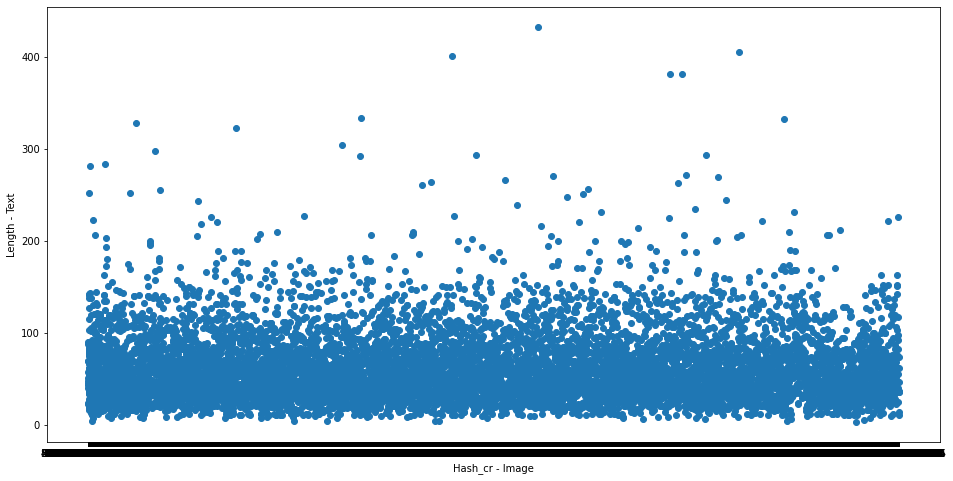

In [93]:
eda_dist['len'] = eda_dist['text'].str.len()

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(eda_dist['hash_cr'], eda_dist['len'])
ax.set_xlabel('Hash_cr - Image')
ax.set_ylabel('Length - Text')
plt.show()

# Hash_Cr min to max: 183550235242215 - 94550201197193

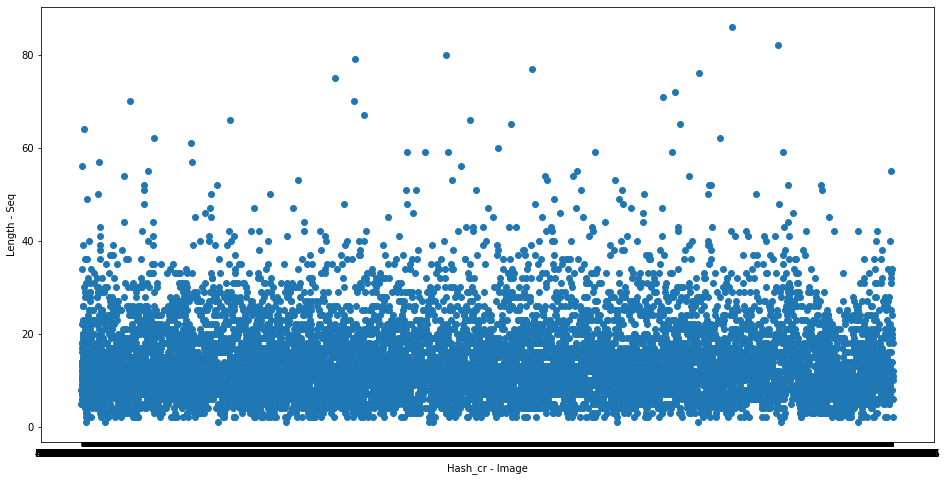

In [94]:
# What max_seq_len is appropriate? - 128 seems good

eda_dist['seq_len'] = eda_dist['text'].apply(lambda x: len(tokenizer_bert.tokenize(x)))

fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(eda_dist['hash_cr'], eda_dist['seq_len'])
ax.set_xlabel('Hash_cr - Image')
ax.set_ylabel('Length - Seq')
plt.show()

id            img  label       text identity  \
45     4876  img/04876.png    0.0       goin    train   
55    89574  img/89574.png    0.0   i'm cute    train   
231   19036  img/19036.png    0.0   infamous    train   
512   75182  img/75182.png    0.0  what bomb    train   
1380   9217  img/09217.png    0.0   overdose    train   
1826  40629  img/40629.png    0.0  hey there    train   
2123  81296  img/81296.png    0.0  a tragedy    train   
2506   9682  img/09682.png    0.0       pals    train   
2524  74096  img/74096.png    0.0       him:    train   
2967  86032  img/86032.png    1.0  come back    train   
3754  61743  img/61743.png    1.0       same    train   
3802  23615  img/23615.png    1.0       real    train   
4842  52349  img/52349.png    1.0  no racism    train   
5107  95186  img/95186.png    0.0  no racism    train   
6048  69710  img/69710.png    0.0  breaktime    train   
6317  30961  img/30961.png    1.0     i see!    train   
6519  94615  img/94615.png    1.0  peinigger    train   
6645  65981  img/65981.png    1.0  ok nigger    train   
6686  64520  img/64520.png    0.0    oh sike    train   
6815  43826  img/43826.png    1.0  king kong    train   

                                         full_path  text_dup  text_dup_slf  \
45    /kaggle/input/fbmdatanopw/data/img/04876.png     False         False   
55    /kaggle/input/fbmdatanopw/data/img/89574.png     False         False   
231   /kaggle/input/fbmdatanopw/data/img/19036.png     False         False   
512   /kaggle/input/fbmdatanopw/data/img/75182.png     False         False   
1380  /kaggle/input/fbmdatanopw/data/img/09217.png      True         False   
1826  /kaggle/input/fbmdatanopw/data/img/40629.png     False         False   
2123  /kaggle/input/fbmdatanopw/data/img/81296.png     False         False   
2506  /kaggle/input/fbmdatanopw/data/img/09682.png     False         False   
2524  /kaggle/input/fbmdatanopw/data/img/74096.png     False         False   
2967  /kaggle/input/fbmdatanopw/data/img/86032.png     False         False   
3754  /kaggle/input/fbmdatanopw/data/img/61743.png      True          True   
3802  /kaggle/input/fbmdatanopw/data/img/23615.png     False         False   
4842  /kaggle/input/fbmdatanopw/data/img/52349.png      True          True   
5107  /kaggle/input/fbmdatanopw/data/img/95186.png      True          True   
6048  /kaggle/input/fbmdatanopw/data/img/69710.png     False         False   
6317  /kaggle/input/fbmdatanopw/data/img/30961.png     False         False   
6519  /kaggle/input/fbmdatanopw/data/img/94615.png     False         False   
6645  /kaggle/input/fbmdatanopw/data/img/65981.png     False         False   
6686  /kaggle/input/fbmdatanopw/data/img/64520.png     False         False   
6815  /kaggle/input/fbmdatanopw/data/img/43826.png     False         False   

                  hash          hash_cr  img_dup0  img_dup1  len  seq_len  
45    a69965cc33cc1c73  400266173173173     False      True    4        1  
55    e3ed14a6126b9c9c  549825238239234     False     False    8        4  
231   9e0dea3b61367462     400324515761     False      True    8        1  
512   9096675772e8a783     800532181921     False     False    9        2  
1380  dbdb8d141159d90d     800533151928     False     False    8        1  
1826  81ac4ad127d8759f  549825252251247     False     False    9        2  
2123  ea443d2b98cde52c  800694116168226     False      True    9        2  
2506  ebc46b9794833686     800615808793     False     False    4        2  
2524  b646eb39c5b6aa04     365550595959     False      True    4        2  
2967  d10ff887de88233c     549825111111     False     False    9        2  
3754  ea94aa5cdb02fc92  400300171185195     False      True    4        1  
3802  e9f8c15f840abe85   36655011913650     False     False    4        1  
4842  a1cb1f615cc634d9     586825524946     False      True    9        2  
5107  f6b5c89c98d53560     549825716351     False      True    9        2  
6048  f0379339c2e66686    282550

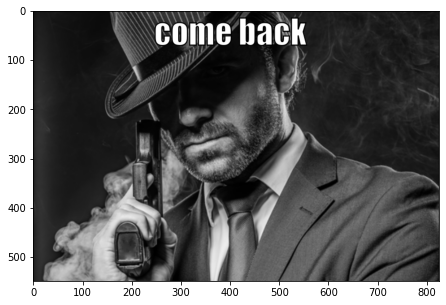

In [95]:
paths = eda_dist.loc[eda_dist.len < 10].full_path.values
path0 = paths[29]

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread('/kaggle/input/fbmdatanopw/data/img/86032.png')
imgplot = plt.imshow(img)

eda_dist.loc[eda_dist.len < 10].head(20)

# Seems like there are none we should remove here - I just dont get most of the labelled ones

- Example with the shortest text

christina ford brett kavanaugh 17 15 i'll take shit that never happened for 1000


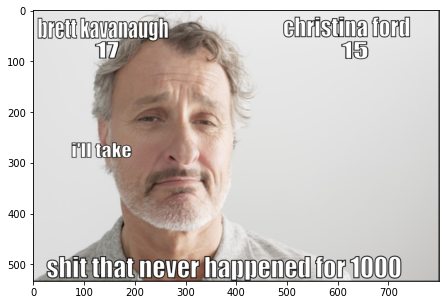

In [102]:
print(eda_dist1.loc[eda_dist1.text.str.contains('christina ford')].text.values[0])
eda_dist1.loc[eda_dist1.text.str.contains('christina ford')]

fig = plt.figure(figsize=[16,12])
plt.subplot(121)
img = mpimg.imread('/kaggle/input/fbmdatanopw/data/img/67935.png')
imgplot = plt.imshow(img)

- very messed up text - it might be beneficial removing the text from the image for the models

## 4.9 Non-hateful hate - Terrorists & co

In [97]:
eda_dist1.loc[eda_dist1.text.str.contains('islamic state')].head(20)

id            img  label  \
4265   4726  img/04726.png    0.0   
7936  41689  img/41689.png    1.0   
72     3976  img/03976.png    NaN   

                                                   text identity  \
4265  islamic state soldiers celebrating we should k...    train   
7936  together, my brothers, the islamic state will ...    train   
72    warning "every" country that has become involv...     test   

                                         full_path  text_dup  text_dup_slf  \
4265  /kaggle/input/fbmdatanopw/data/img/04726.png     False         False   
7936  /kaggle/input/fbmdatanopw/data/img/41689.png     False         False   
72    /kaggle/input/fbmdatanopw/data/img/03976.png     False         False   

                  hash          hash_cr  img_dup0  img_dup1  
4265  b23f36e3c8e0d838     775825446286     False      True  
7936  f17c14ab83f13c2c  366550166151110     False     False  
72    cc2719c87e716639     366550323921     False     False

         id            img  label  \
361    1896  img/01896.png    0.0   
3359  46193  img/46193.png    1.0   
3973  16892  img/16892.png    0.0   
4442  41208  img/41208.png    1.0   

                                                   text identity  \
361   terrorism is just part and parcel of living in...    train   
3359  when it's 1942 and you're jewish dj khaled suf...    train   
3973  farrakhan speech at united center in chicago b...    train   
4442  breaking news nation of islam members listen t...    train   

                                         full_path  text_dup  text_dup_slf  \
361   /kaggle/input/fbmdatanopw/data/img/01896.png     False         False   
3359  /kaggle/input/fbmdatanopw/data/img/46193.png     False         False   
3973  /kaggle/input/fbmdatanopw/data/img/16892.png     False         False   
4442  /kaggle/input/fbmdatanopw/data/img/41208.png     False         False   

                  hash          hash_cr  img_dup0  img_dup1  
361   9fafa4b05ae4e2

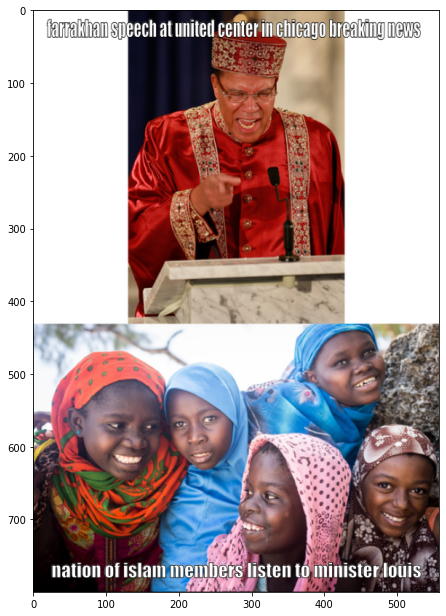

In [98]:
print(eda_dist1.loc[eda_dist1.text.str.contains('kha')])

paths = eda_dist1.loc[eda_dist1.text.str.contains('kha')].full_path.values

path0 = paths[2]

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(path0)
imgplot = plt.imshow(img)

## 4.10 Model mistake analysis

id            img  label  \
105   80521  img/80521.png    0.0   
140   91754  img/91754.png    0.0   
404   68042  img/68042.png    0.0   
581   76328  img/76328.png    0.0   
885   30276  img/30276.png    0.0   
925   69018  img/69018.png    0.0   
1049  89640  img/89640.png    1.0   
1321   4976  img/04976.png    0.0   
1336  94278  img/94278.png    0.0   
1375  16072  img/16072.png    1.0   

                                                   text identity  \
105   him: the dishwasher is acting weird her: what'...    train   
140   when you finally buy a dishwasher this works a...    train   
404          i think i almost got my dishwasher working    train   
581                  broken dishwasher for sale or rent    train   
885   when the dishwasher isn't working properly and...    train   
925              when you slap your dishwasher too hard    train   
1049  when your girlfriend buys a dishwasher this is...    train   
1321  shit someone added too much soap to the dishwa...    train   
1336        stop it! i'm trying to work with dishwasher    train   
1375  remember when you needed to bang your tv to ge...    train   

                                         full_path  text_dup  text_dup_slf  \
105   /kaggle/input/fbmdatanopw/data/img/80521.png      True          True   
140   /kaggle/input/fbmdatanopw/data/img/91754.png      True          True   
404   /kaggle/input/fbmdatanopw/data/img/68042.png      True          True   
581   /kaggle/input/fbmdatanopw/data/img/76328.png      True          True   
885   /kaggle/input/fbmdatanopw/data/img/30276.png      True          True   
925   /kaggle/input/fbmdatanopw/data/img/69018.png     False         False   
1049  /kaggle/input/fbmdatanopw/data/img/89640.png     False         False   
1321  /kaggle/input/fbmdatanopw/data/img/04976.png     False         False   
1336  /kaggle/input/fbmdatanopw/data/img/94278.png     False         False   
1375  /kaggle/input/fbmdatanopw/data/img/16072.png     False         False   

                  hash          hash_cr  img_dup0  img_dup1  
105   d0df81f569175a88     366550286619     False     False  
140   e5a656633e4b1983  366550142141140     False      True  
404   b1a8c4d2919b7b6c  800600210207190     False     False  
581   db71147fc914036b     366550355381     False      True  
885   bc8263e23da559a6  366550163155141     False     False  
925   b8cacf39fd060ac1  800597218219213     False     False  
1049  a1da9fe44213adb8  400266163164169     False     False  
1321  c9b3926e128db54e  366550225222223     False      True  
1336  93c37448cca67f94     549825767366     False      True  
1375  81b4d395795e27a2     366550455753     False     False

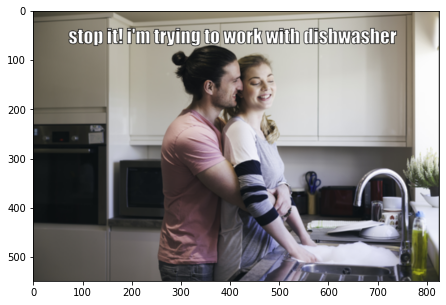

In [99]:
# The Dishwasher - 144 examples containing this
paths = eda_dist1.loc[eda_dist1.text.str.contains('dishwasher')].full_path.values

path0 = paths[8]

fig = plt.figure(figsize=[16,12])

plt.subplot(121)
img = mpimg.imread(path0)
imgplot = plt.imshow(img)


eda_dist1.loc[eda_dist1.text.str.contains('dishwasher')].head(10)

# 5. Model Data

Let us now take some of the insights formed and create different models. Going forward, we will likely iterate back and forth within this step, while also doing some more exploratory analysis. 

## 5.1 Establishing a baseline – Human error

To optimize our algorithm, it is useful to get an idea of human performance. For vision tasks, one can even take the human error for an estimate of the Bayes Error, due to our vision capabilities. Before knowing too much about our data we will do a quick test of the human error and lateron in the 5th phase, perhaps a more sophisticated human model. 

# Human Error reproduction - Remove docstring comment to try

# Choose 100 random samples & estimate human error
'''
random_state = 0
n = 100

sample_df = dev_df.sample(n, random_state=random_state)

labels = sample_df['label'].to_numpy(dtype=int)
human_pred = np.zeros((n), dtype=int)

for i in range(n):
    print('Text: ', sample_df.iloc[i]['text'])
    human_guess = input()
    human_pred[i] = human_guess

score = sklearn.metrics.roc_auc_score(labels, human_pred)
print('Human Score unimodal on text is:', score)
'''

### Saving human input for reference
<details>
  <summary>Human Guesses</summary>
  
  
Text:  potato is my favorite color of the alphabet
0
Text:  happy birthday you sexy beast
1
Text:  time to put the "panic" back in hispanic
1
Text:  doing o's with the smoke
0
Text:  first friday prayers of the islamic holy day
1
Text:  my sense of humor is so dark it picks cotton
1
Text:  i could have killed all of them. but i let some of them survive so you know why i killed them
1
Text:  every kitchen needs a sandwich maker just like this one
1
Text:  they see them rollin..... they hating..
0
Text:  white power!
1
Text:  you can make jokes about anything, just not illegals that's crossing the border
1
Text:  goat meat is very popular in islamic countries
1
Text:  eat some cookies you're not yourself when you're hungry
0
Text:  if she's still making noises, you didn't hit her hard enough
1
Text:  free blanket maybe white man not so bad after all
0
Text:  the original scarecrow
0
Text:  when finishing a race is your passion
0
Text:  the door to the crematorium and gas chambers are closed
1
Text:  when you know you don't have to jackoff tonight
1
Text:  she said girls run the world... so i told her get back in the kitchen
1
Text:  for lunch vlad the impaler loved turkey
0
Text:  and at that moment everything else in the world just melted away
0
Text:  the secret to a successful marriage is to keep his stomach full and his balls empty
0
Text:  welcome to melbourne
0
Text:  49 people were killed at christchurch muslim 49 people were killed at christchurch mosques muslim
1
Text:  it's the goat humper looks like a bunch of pigs just walked over your grave
1
Text:  white people on cinco de mayo vs. every other day
0
Text:  taking the liberals to a whole new level
0
Text:  those stupid basterds thought it was a real shower
1
Text:  no wonder why the pipes are not working
0
Text:  when your company valuation hits 1 billion
0
Text:  they see them rollin.... they hating..
0
Text:  i just started a company selling landmines that look like prayer mats prophets are going through the roof
0
Text:  on tuesday, november 3, 2020, we make america great again  by voting this nightmare out of office!
0
Text:  i ordered a dishwasher and they sent me a sandwich maker
1
Text:  leaving a trail of death and destruction
0
Text:  the proper way to pop a blackhead
1
Text:  she represents the new wave of democrats
0
Text:  traveling through chimney
1
Text:  i finally found my girlfriends g-spot turns out it was in her sister the whole time
0
Text:  still better than mexican
1
Text:  money is evil give it to us
0
Text:  you don't need cocaine to be happy
0
Text:  i said "a glass of juice".
0
Text:  face of terrorism in us
1
Text:  bravery at its finest
0
Text:  size of a shuttle bus legroom of a pinto
0
Text:  hey, i just met you and this is crazy but here's your number.. so camping, maybe?
0
Text:  taking a photo with family
0
Text:  white power!
1
Text:  it's time we took guns away and put them out of the reach of our children
0
Text:  america in 2045 "grandpa...why didn't you stop them?!"
1
Text:  the proper way to pop a blackhead
1
Text:  if the brim of your hat is flat and has a sticker on it i automatically assume you're a complete tool
0
Text:  what do alcoholics and necrophiliacs have in common they both love to crack open a cold one.
1
Text:  enough is enough children are more important than freaks
0
Text:  they are terrorists anyone who doesn't agree is an idiot
1
Text:  how about a nice 12 yr old? bartender: him: boy i would love that
1
Text:  when your friend insists on paying for dinner but you still want to contribute - just the tip, come on... let me
0
Text:  i believe they are like racism just shouldn't exist
1
Text:  "god's chosen people" according to the book they wrote
0
Text:  everyone is afraid of dark
1
Text:  the definition of utter disgust in plain black and white
1
Text:  in the last days there will be god hating scoffers, ridiculers, deniers and mockers following after their own lusts
0
Text:  i forgot what are we fighting over again?
0
Text:  i love apes they are both ugly and cute
0
Text:  dat ass ahmarbkrich*d
1
Text:  doing o's with the smoke
0
Text:  waves mexican flag doesn't want to live in mexico
1
Text:  potato is my favorite color of the alphabet
1
Text:  and for my next class project!
0
Text:  i started a business that sells landmines disguised as prayer mats.. ..prophets are going through the roof
1
Text:  a cat in a pot
0
Text:  broken dishwasher
0
Text:  we want sharia law !! well.... go home
1
Text:  when you ask a jewish girl for her number and she starts rolling her sleeve
1
Text:  theriously?? that's methed up!
0
Text:  today we are making vegetable soup
0
Text:  last summer camp was so "lit"
0
Text:  when you have someone to help and take care of you what could happen if you didn't
0
Text:  haters will say it's photoshop
0
Text:  whenever you feel stupid, remember there are people who throw stones at a wall! aiming for an invisible devil, told by an invisible god for an invisible heaven!
1
Text:  does nike also sell stones in case they take it off?
0
Text:  america taught us how to be happy slaves the same way school teach us how to be happy employees
1
Text:  nein danke i'm very happy with my gas supplier
1
Text:  wouldn't be the last time those people used the oven this way
1
Text:  randomly deciding to bake something
1
Text:  we've taken this country! now fuck off! we're taking it back!
1
Text:  hitting is a crime. it's about time people understood that
0
Text:  nurse: yes sir, we are having mashed potatoes today alzheimer's patient: i don't remember asking you a god damn thing
0
Text:  in just one hour from now i'll only have 4 hours left until i have to work a mere 3 hours
0
Text:  take the third reich and then the first left?
1
Text:  love is love
0
Text:  i like my rice crispy please
1
Text:  "white privilege the privilege of being called "racist" by other people who see nothing else about you except the color of your skin
1
Text:  white kids kids dreaming about their first day of school
1
Text:  under the name of multiculturalism we let terrorist into this country
1
Text:  cotton candy is what makes the theme park wonderful
1
Text:  when you decide to go full gas
1
Text:  "he's a squirter" doesn't sound as sexy when you are gay
1
</details>


    Human Score unimodal on text is: 0.5903251706142111



I scored 59.032%, hence let us assume the human score is roughly 60% +- 5%, purely from text (without having looked at word frequencies).



The human score for the image itself (incl. text) is given in the paper (Source 1):

**Acc: 84.70% Roc_Auc: 82.65%**

## 5.2 Building the models

In this step, we will implement our modules in classes. This makes them easy to move between Notebooks & Script. Going forward this is where most of the time will be spent.

## 5.2.1 Handcoded Neural Network analysing sentiment based on ratios - TEXT ONLY MODEL

In [11]:
class TextSentiment:
    
    def __init__(self, train_df, dev_df, test_df, min_count=0, polarity_cutoff=0, lr=0.01,
                 hidden_layers=1, hidden_nodes=[5], nn_cut=False, epochs=1):
        """
        
        """
        
        assert len(hidden_nodes) == hidden_layers
    
        # To ensure reproducable results
        np.random.seed(1)

        self.train_df = train_df.copy(deep=True)
        self.dev_df = dev_df.copy(deep=True)
        self.test_df = test_df.copy(deep=True)

        self.pre_process_df()

        # Hyperparameters for ratio model
        self.min_count = min_count
        self.polarity_cutoff = polarity_cutoff
        
        # Hyperparameters for nn model w/ 1 hidden layer
        self.hidden_nodes = hidden_nodes[0]
        self.output_nodes = 1
        self.lr = lr
        self.nn_cut = nn_cut
        self.epochs = epochs

    def pre_process_df(self):
        
        for df in [self.train_df, self.dev_df, self.test_df]:
            # Removing punctuation & setting to lower case
            df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '')
            df['text'] = df['text'].str.lower()
            
        
    def ratio_model(self, test_bool=False):
        
        if test_bool:
            tr_dv_df = pd.concat([self.train_df, self.dev_df])
            ratio = self.create_ratio(tr_dv_df)
            # Training Error
            self.ratio_test(tr_dv_df, ratio)
            print('-'*50)
            # Test Error
            self.ratio_test(self.test_df, ratio, sub_bool=True)
        else:
            ratio = self.create_ratio(self.train_df)
            # Training Error
            self.ratio_test(self.train_df, ratio)
            print('-'*50)
            # Dev Error
            self.ratio_test(self.dev_df, ratio)
            
    def create_ratio(self, df):
        
        hate_counts = Counter()
        nonhate_counts = Counter()
        total_counts = Counter()
        
        hate_nonhate_ratio = Counter()

        for index, row in df.iterrows():
            if row['label'] == 1:
                for word in row['text'].split(' '):
                    hate_counts[word] += 1
                    total_counts[word] += 1
            if row['label'] == 0:
                for word in row['text'].split(' '):
                    nonhate_counts[word] += 1
                    total_counts[word] += 1
        
        # LEARNING:
        # bias = len(df.loc[df['label'] == 1]) / len(df.loc[df['label'] == 0]) 
        # This is wrong, as hateful memes are longer in their text on average by 20% chars:
        # avg_len = df.loc[df['label'] == 1].apply(len).mean()
        
        # Bias (As more nonhate examples & diff word count per meme)
        bias = sum(hate_counts.values()) / sum(nonhate_counts.values())
            
        for word, count in total_counts.most_common():
            if count > self.min_count:
                hc = float(hate_counts[word])
                nhc = float(nonhate_counts[word] * bias)

                # Hateful word
                if hc > nhc:
                    hate_nonhate_ratio[word] = np.log(hc / (nhc + 1))

                # Non-hateful word
                if nhc > hc:
                    hate_nonhate_ratio[word] = - np.log(nhc) / (hc + 1)
        
        # Cutting off small values:
        for word, ratio in hate_nonhate_ratio.most_common():
            if np.abs(ratio) < self.polarity_cutoff:
                del hate_nonhate_ratio[word]
        
        return hate_nonhate_ratio
    
                    
    def ratio_test(self, df, ratio, sub_bool=False):
        
        proba = []
        label = []
        
        # Score the examples
        for idx, row in df.iterrows():
            score = 0
            for word in row['text'].split(' '):
                if word in ratio:
                    score += ratio[word]
            
            # Turn into value between 0 & 1
            proba.append(self.sigmoid(score))
            
            # Assigning 0's to hateful to equalize share towards 50
            label.append(0) if score < 0 else label.append(1)
        
        # AUC ROC Scores
        if 'label' in df.columns:
            roc_auc = sklearn.metrics.roc_auc_score(df['label'], proba)
            accuracy = sklearn.metrics.accuracy_score(df['label'], label)
            print('ROC_AUC_SCORE: ', roc_auc)
            print('ACCURACY: ', accuracy)
        
        # Percentage hateful (As balanced should not be too far off from 50%)
        print('Hateful Percentage: ', sum(label) / len(label))
            
        # Submission ; assign creates a copy of the df hence no chain indexing probs
        if sub_bool:
            sub_df = df[['id']].assign(proba=proba, label=label)
            sub_df.to_csv('ratazzioni_1.1.csv', index=False)
            
    def length_model(self, test_bool=False):
        
        if test_bool:
            None
        else:
            avg_len_hate = self.train_df.loc[self.train_df['label'] == 1].apply(len).mean()
            avg_len_nonhate = self.train_df.loc[self.train_df['label'] == 0].apply(len).mean()
            
            
        
    def nn_model(self, test_bool=False):
        
        if test_bool:
            tr_dv_df = pd.concat([self.train_df, self.dev_df])
            self.nn_init(tr_dv_df)
            self.nn_train(tr_dv_df)
            self.nn_submit(self.test_df)
            
        else:
            self.nn_init(self.train_df)
            self.nn_train(self.train_df, self.dev_df)
            
    
    def nn_init(self, df):
        
        # Create Vocab w/ unique words
        if self.nn_cut == False:
            self.vocab = set()
            for idx, row in df.iterrows():
                for word in row['text'].split(' '):
                    self.vocab.add(word)
            self.vocab_len = len(self.vocab)
        
        # Cutoff min_count & polarity
        else:
            h_nh_ratio = self.create_ratio(df)
            self.vocab = set(h_nh_ratio.keys())
            self.vocab_len = len(self.vocab)
        
        
        # Create index for each word
        self.word2index = dict()
        for idx, word in enumerate(self.vocab):
            self.word2index[word] = idx
            
        
            
        # Initalize layers
        #self.W1 = np.random.normal(scale=0.2, size=(self.vocab_len, self.hidden_nodes))
        self.W1 = np.zeros((self.vocab_len, self.hidden_nodes))
        self.W2 = np.random.normal(scale=self.hidden_nodes**-0.5,
                              size=(self.hidden_nodes, self.output_nodes))
        # W2 = np.zeros((self.hidden_nodes, self.output_nodes))
        

    def one_hot_encode(self, text):
        
        one_hot_vector = np.zeros((1, self.vocab_len))
        
        for word in text.split(' '):
            if word in self.word2index:
                one_hot_vector[:, self.word2index[word]] += 1
        
        return one_hot_vector
    
    def nn_train(self, train_df, dev_df=None):
        """
        W1: Shape: vocab_len, hidden_nodes
        W2: Shape: hidden_nodes, output_nodes
        
        """
        
        for e in range(self.epochs):
            
            running_loss = 0
            correct_so_far = 0
            train_pred = []
            train_labels = []
        
            for idx, row in train_df.iterrows():

                feature = self.one_hot_encode(row['text']) # Shape: 1, vocab_len
                label = row['label'] # Shape: 1

                # Forward
                Z1 = np.dot(feature, self.W1) # Shape: 1, hidden_nodes
                A1 = Z1 # Shape: 1, hidden_nodes

                Z2 = np.dot(A1, self.W2) # Shape: 1, output_nodes
                A2 = self.sigmoid(Z2) # Shape: 1, output_nodes
                

                # Loss - MSE
                loss = 0.5 * np.sum(np.square(A2 - label))

                # Backward
                dZ2 = (A2 - label) * self.sigmoid_derivative(A2) # Shape: 1, output_nodes
                dW2 = np.dot(A1.T, dZ2) # Shape: hidden_nodes, output_nodes

                dZ1 = np.dot(dZ2, self.W2.T) # * self.relu_derivative(Z1) # Shape: 1, hidden_nodes
                dW1 = np.dot(feature.T, dZ1) # Shape: vocab_len, hidden_nodes

                self.W2 -= dW2 * self.lr
                self.W1 -= dW1 * self.lr

                if np.round(A2) == label:
                    correct_so_far += 1
                    
                train_pred.append(A2[0][0])
                train_labels.append(label)
                

                running_loss += loss
                
            train_acc = correct_so_far / len(train_df)

            # Validate
            if dev_df is not None:
                
                correct_so_far = 0
                dev_pred = []
                dev_labels = []
                
                for idx, row in dev_df.iterrows():

                    feature = self.one_hot_encode(row['text']) # Shape: 1, vocab_len
                    label = row['label'] # Shape: 1

                    # Forward
                    Z1 = np.dot(feature, self.W1) # Shape: 1, hidden_nodes
                    A1 = Z1 # Shape: 1, hidden_nodes

                    Z2 = np.dot(A1, self.W2) # Shape: 1, output_nodes
                    A2 = self.sigmoid(Z2) # Shape: 1, output_nodes
                    
                    if np.round(A2) == label:
                        correct_so_far += 1
                        
                    dev_pred.append(A2[0][0])
                    dev_labels.append(label)
                
                dev_acc = correct_so_far / len(dev_df)
                
            else:
                dev_acc = 'X'
                dev_labels = [0, 1]
                dev_pred = [0, 1]
                
            print('Progress: {}, Loss: {}, TrainAcc: {}, DevAcc: {}'.format(e+1, running_loss,
                                                                            train_acc, dev_acc))
            
            print('Tr_rocauc: {}, Dv_rocauc: {}'.format(sklearn.metrics.roc_auc_score(train_labels, 
                                                                                      train_pred),
                                                       sklearn.metrics.roc_auc_score(dev_labels, 
                                                                                      dev_pred)))
    def nn_submit(self, df):
        
        proba = []
        label = []
        
        for idx, row in df.iterrows():
            
            feature = self.one_hot_encode(row['text'])
       
            Z1 = np.dot(feature, self.W1) # Shape: 1, hidden_nodes
            A1 = Z1 # Shape: 1, hidden_nodes

            Z2 = np.dot(A1, self.W2) # Shape: 1, output_nodes
            A2 = self.sigmoid(Z2) # Shape: 1, output_nodes
            
            proba.append(A2[0][0])
            label.append(int(np.round(A2[0][0])))
        
        sub_df = df[['id']].assign(proba=proba, label=label)
        sub_df.to_csv('firefly_1.0.csv', index=False)
        
        
    def get_most_similar_words(self, focus="jews"):
    
        most_similar = Counter()

        for word in Model.word2index.keys():
            most_similar[word] = np.dot(self.W1[self.word2index[word], :],
                                        self.W1[self.word2index[focus], :])
        
        return most_similar.most_common()
  
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        # This is the sigmoid derivate given the result! (i.e. A not Z) 
        # The 'real' one would be for Z -> sigmoid(Z) * 1 - sigmoid(Z)
        return x * (1 - x)
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        x[x <= 0] = 0
        x[x > 0] = 1
        return x

In [14]:
### Training the model ####
Model = TextSentiment(train_df, dev_df, test_df, min_count=0, polarity_cutoff=0.5, 
                      hidden_nodes=[5], lr=0.01, nn_cut=True, epochs=10)
Model.nn_model(test_bool=False)
Model.get_most_similar_words(focus = "nigga")[:10]

Progress: 1, Loss: 1056.03981044933, TrainAcc: 0.7148235294117647, DevAcc: 0.578
Tr_rocauc: 0.7188531207700406, Dv_rocauc: 0.5992879999999999
Progress: 2, Loss: 1041.6201257226728, TrainAcc: 0.729764705882353, DevAcc: 0.578
Tr_rocauc: 0.7737297037148443, Dv_rocauc: 0.598648
Progress: 3, Loss: 1026.6124173269948, TrainAcc: 0.7316470588235294, DevAcc: 0.578
Tr_rocauc: 0.7783096405474508, Dv_rocauc: 0.598808
Progress: 4, Loss: 1010.8006997492275, TrainAcc: 0.7331764705882353, DevAcc: 0.576
Tr_rocauc: 0.7805666416002407, Dv_rocauc: 0.5961519999999999
Progress: 5, Loss: 994.2171570559497, TrainAcc: 0.7356470588235294, DevAcc: 0.572
Tr_rocauc: 0.7829404722514663, Dv_rocauc: 0.59204
Progress: 6, Loss: 976.7519538288407, TrainAcc: 0.7395294117647059, DevAcc: 0.574
Tr_rocauc: 0.7857217025116559, Dv_rocauc: 0.59244
Progress: 7, Loss: 958.551336993903, TrainAcc: 0.7454117647058823, DevAcc: 0.576
Tr_rocauc: 0.7896407279290119, Dv_rocauc: 0.5922160000000001
Progress: 8, Loss: 940.1378300178837, Tra

[('jews', 0.018520275455452415),
 ('nigger', 0.01316587931664163),
 ('islam', 0.011958138343870927),
 ('niggers', 0.009081904755767393),
 ('transgender', 0.008846514988314126),
 ('word', 0.008527186447411461),
 ('tranny', 0.007557943603093173),
 ('auschwitz', 0.007461924903328456),
 ('muslims', 0.007352464265225047),
 ('pussy', 0.007122790416555106)]

In [15]:
Model2 = TextSentiment(train_df, dev_df, test_df, min_count=1, polarity_cutoff=0.25)
Model2.ratio_model(test_bool=True)

ROC_AUC_SCORE:  0.8034195374800638
ACCURACY:  0.6853333333333333
Hateful Percentage:  0.538
--------------------------------------------------
Hateful Percentage:  0.581


- The models above are purely based on text (i.e. they dont see the image of the meme)
- They get close to the accuracy I reported as a human of ~60%

## 5.2.2 BERT Transformer pre-trained on Hateful texts ("HateBert") - TEXT ONLY MODEL

In [12]:
class HateBert:
    
    def __init__(self, train_df, dev_df, test_df=None, batch_size=32, min_count=0,
                 betas=(0.9, 0.999), warmup_steps=0, lr=2e-5, cos_schedule=False, grad_clip=True, 
                 epochs=1, test_bool=False, hate_cnerg=False):
        """
        Iniatlizes HateBert.
        """
        self.test_bool = test_bool
        self.batch_size = batch_size
        self.lr = lr
        self.betas = betas
        self.warmup_steps = warmup_steps
        self.epochs = epochs
        self.cos_schedule = cos_schedule
        self.grad_clip = grad_clip
        self.hate_cnerg = hate_cnerg
        
        if self.test_bool:
            self.train_df = pd.concat([train_df, dev_df])
            self.test_df = test_df
        else:
            self.train_df = train_df
            self.test_df = dev_df
        
        self.init_model()
        
        
        # Only save the best models
        # Defining this here instead of in the tr loop, allows to train multiple times
        self.top_roc_auc = 0.5
        self.save_csv = 0
        
        # Ensure same randomness -- Seems there is still some randomness involved
        random_seed = 42
        
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed_all(random_seed)
        
    def add_vocab(self):
        

        print(len(self.tokenizer))  # 28996
        self.tokenizer.add_tokens(add_voc)
        print(len(self.tokenizer))  # 28997

        self.model.resize_token_embeddings(len(self.tokenizer)) 
        # The new vector is added at the end of the embedding matrix

        # print(self.model.bert.embeddings.word_embeddings.weight[-1, :])
        # Randomly generated matrix

        # self.model.bert.embeddings.word_embeddings.weight[-1, :] = torch.zeros([self.model.config.hidden_size])

        # print(self.model.bert.embeddings.word_embeddings.weight[-1, :])

        
    def encode(self):
        """
        Encodes Train & Test DF into BERT-readable format.
        """
        
        if self.hate_cnerg == False:
            #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
            self.tokenizer = AutoTokenizer.from_pretrained('roberta-base', do_lower_case=True)
        else:
            self.tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english", 
                                                           do_lower_case=True)
            
        # Add necessary vocab
        #self.add_vocab()   
            
        
        encode_train = self.tokenizer.batch_encode_plus(list(self.train_df['text'].values), 
                                                  add_special_tokens=True,
                                                  return_attention_mask=True,
                                                  pad_to_max_length=True,
                                                  max_length=128, return_tensors='pt')
        
        encode_test = self.tokenizer.batch_encode_plus(list(self.test_df['text'].values), 
                                                  add_special_tokens=True,
                                                  return_attention_mask=True,
                                                  pad_to_max_length=True,
                                                  max_length=128, return_tensors='pt')
        
        
        
        input_ids_train = encode_train['input_ids']
        attention_masks_train = encode_train['attention_mask']
        labels_train = torch.tensor(self.train_df['label'].values)

        input_ids_test = encode_test['input_ids']
        attention_masks_test = encode_test['attention_mask']
        
        if self.test_bool==False:
            labels_test = torch.tensor(self.test_df['label'].values)
        else:
            # Create a random tensor in case no labels column exists
            labels_test = labels_train.clone()[:input_ids_test.shape[0]]
            print('Creating trivial labels for test – Ignore Test Loss & Scores.')
        
        dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
        dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
        
        self.trainloader = DataLoader(dataset_train, batch_size=self.batch_size,
                                      sampler=RandomSampler(dataset_train))
        
        self.testloader = DataLoader(dataset_test, batch_size=self.batch_size,
                                      sampler=SequentialSampler(dataset_test))
        
        # Print amount of batches
        print('Constructed {} training & {} testing batches.'.format(len(self.trainloader), 
                                                                    len(self.testloader)))
        # Calculate how many steps for LR decay
        self.total_steps = self.epochs * len(self.trainloader)
                                     
    def init_model(self):
        """
        Initalizes the model, optimizer & scheduler.
        """
        
        # 12-layer BERT Model w/ uncased vocab  
        if self.hate_cnerg == False:
            #self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
            #                                                           num_labels = 2, 
            #                                                           output_attentions = False, 
            #                                                           output_hidden_states = False)
            self.model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
        else:
            self.model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
        
        # Encode batches
        self.encode()
        
        self.optimizer = AdamW(self.model.parameters(), lr=self.lr, betas=(0.9, 0.98), eps=1e-8)
        self.scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                                                         num_warmup_steps=self.warmup_steps, 
                                                         num_training_steps=self.total_steps)
        
        if self.cos_schedule:
            self.scheduler = get_cosine_schedule_with_warmup(self.optimizer, 
                                                             num_warmup_steps=self.warmup_steps, 
                                                             num_training_steps=self.total_steps)
        
       
    def get_device(self):
        '''
        Returns the device to be used for training.
        '''
        
        # If there's a GPU available...
        if torch.cuda.is_available():    

            # Tell PyTorch to use the GPU.    
            device = torch.device("cuda")

            print('There are %d GPU(s) available.' % torch.cuda.device_count())
            print('We will use the GPU:', torch.cuda.get_device_name(0))

        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")
            
        return device
    
    def format_time(self, elapsed):
        '''
        Takes a time in seconds and returns a string hh:mm:ss
        '''
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))

        # Format as hh:mm:ss
        return str(datetime.timedelta(seconds=elapsed_rounded))
    
    def calc_metrics(self, logits, labels, sub_bool=False, plot_roc=False, plot_ss=False):
        '''
        Calculates & returns accuracy & roc_auc_score.
        
        Args:
        logits: List of np.arrays of shape batch_size x num_labels
        labels: List of np.arrays of shape (batch_size, ) 
        
        Returns:
        roc_auc
        accuracy
        '''
        # Concatenate lists of arrays on axis=0
        LO = np.concatenate(logits)
        LA = np.concatenate(labels)

        # num_labels = 2
        # Get the maximum value along axis 1
        LO_probs = LO[:, 1]

        # Get the index of the max value
        LO = np.argmax(LO, axis=1).flatten()
        LA = LA.flatten()

        roc_auc = sklearn.metrics.roc_auc_score(LA, LO_probs)
        accuracy = sklearn.metrics.accuracy_score(LA, LO)
        
        hate_perc = sum(LO) / len(LO)
        
        if (roc_auc > self.top_roc_auc) and (sub_bool == False):
            print('ROC AUC IMPROVED FROM {} to {}.'.format(self.top_roc_auc, roc_auc))
            self.top_roc_auc = roc_auc
            self.save_csv = 1
        
        # Submit
        if sub_bool and self.save_csv==1:
            sub_df = self.test_df[['id']].assign(proba=LO_probs.tolist(), 
                                                 label=LO.tolist())
            
            print('Saving CSV ...')
            sub_df.to_csv('HateBert_1.1.csv', index=False)
            self.save_csv = 0
        
        # Plot ROC
        if plot_roc:
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(LA, LO_probs)
            
            plt.figure()
            
            # Diagonal (Area = 0.5)
            plt.plot([0,1], [0,1], color='navy', ls='--')
            
            # ROC Curve of our logits
            plt.plot(fpr, tpr, color='darkorange')

            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('AUC ROC')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.show()
        
        # Plot Sensitivity & Specificity
        if plot_ss:
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(LA, LO_probs)
            
            specificity = 1 - fpr
            
            plt.figure()
            
            # Diagonal (Area = 0.5)
            plt.plot([0,1], [1,0], color='navy', ls='--')
            
            # ROC Curve of our logits
            plt.plot(specificity, tpr, color='darkorange')

            plt.xlabel('Specificity')
            plt.ylabel('Sensitivity')
            plt.title('SS Curve')

            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.show()

        return roc_auc, accuracy, hate_perc
    
    def train(self, sub_bool=False):
        """
        Trains the model.
        """
        self.device = self.get_device()
        self.model = self.model.to(self.device)
        
        total_t0 = time.time()
        
        # Define softmax layer to apply to logit outputs
        softmax = nn.Softmax(dim=1)
    
        for epoch in range(self.epochs):
            
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch + 1, self.epochs))
            print('Training...')
            
            # Measure time of each epoch
            t0 = time.time()
            
            # Accumulate Loss
            total_train_loss = 0
            
            self.model.train()
            
            train_logits, train_labels = [], []
            
            for step, batch in enumerate(self.trainloader):
                
                # Report Progress
                if (step+1) % 50 == 0:
                    elapsed = self.format_time(time.time() - t0)
                    print('Batch {} of {}    Elapsed: {}'.format(step+1, len(self.trainloader),
                                                                 elapsed))
                # Clear grads
                self.model.zero_grad()
                          
                # Extract content of batch as we specified in self.encode 
                batch = tuple(t.to(self.device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch
                          
                # Perform forward pass
                output = self.model(b_input_ids, token_type_ids=None, 
                                         attention_mask=b_input_mask, labels=b_labels)
                loss, logits = output["loss"], output["logits"]
                #print("OUT", output)
                #print(loss, logits)
                          
                # Add loss
                total_train_loss += loss.item()
                
                # Apply softmax to logits
                logits = softmax(logits)
                
                # Append Logits & Labels for scoring
                train_logits.append(logits.detach().cpu().numpy())
                train_labels.append(b_labels.cpu().numpy())
                
                # Backrpopagate
                loss.backward()
                
                # Clipping grads
                if self.grad_clip:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 5.0)
                
                # Update Weights & LR
                self.optimizer.step()
                self.scheduler.step()
                
                # For CPU tests
                #if step==1:
                #    print('Stopping')
                #    break
                
            # Calculate & print loss & time
            roc_auc, acc, hate_perc = self.calc_metrics(train_logits, train_labels)
            avg_train_loss = total_train_loss / len(self.trainloader)
            training_time = self.format_time(time.time() - t0)
                          
            print("")
            print("  Hateful Percentage: {0:.4f}".format(hate_perc))
            print("  Train ROC_AUC: {0:.4f}".format(roc_auc))
            print("  Train Accuracy: {0:.4f}".format(acc))
            print("  Average training loss: {0:.4f}".format(avg_train_loss))
            print("  Training epoch took: {:}".format(training_time))
            
            print("")
            print("Running Test...")

            t0 = time.time()
                          
            total_test_loss = 0
            
            self.model.eval()
            
            test_logits, test_labels = [], []
            
            for batch in self.testloader:
                
                batch = tuple(t.to(self.device) for t in batch)
                
                b_input_ids, b_input_mask, b_labels = batch
                    
                with torch.no_grad():
                    output = self.model(b_input_ids, token_type_ids=None, 
                                        attention_mask=b_input_mask, labels=b_labels)
                    loss, logits = output["loss"], output["logits"]
                    total_test_loss += loss.item()  
        
                # Apply softmax to logits
                logits = softmax(logits)
                
                # Append Logits & Labels for scoring
                test_logits.append(logits.detach().cpu().numpy())
                test_labels.append(b_labels.cpu().numpy())
                
                # For CPU tests
                #if step==1:
                #    print('Stopping')
                #    break

            roc_auc, acc, hate_perc = self.calc_metrics(test_logits, test_labels, sub_bool)
            avg_test_loss = total_test_loss / len(self.testloader)
            test_time = self.format_time(time.time() - t0)
            
            print("")
            print("  Hateful Percentage: {0:.4f}".format(hate_perc))
            print("  Test ROC_AUC: {0:.4f}".format(roc_auc))
            print("  Test Accuracy: {0:.4f}".format(acc))
            print("  Average test loss: {0:.4f}".format(avg_test_loss))
            print("  Test epoch took: {:}".format(test_time))
                          
        print("")
        print("Training complete!")
        print("Total training took {:} (h:mm:ss)".format(self.format_time(time.time()-total_t0)))

In [15]:
Model_HB = HateBert(train_df, dev_df, epochs=10, batch_size=8, lr=5e-5, test_bool=False, hate_cnerg=False)
Model_HB.train(sub_bool=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

Constructed 1063 training & 63 testing batches.
There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB

======== Epoch 1 / 10 ========
Training...
Batch 50 of 1063    Elapsed: 0:00:07
Batch 100 of 1063    Elapsed: 0:00:14
Batch 150 of 1063    Elapsed: 0:00:21
Batch 200 of 1063    Elapsed: 0:00:28
Batch 250 of 1063    Elapsed: 0:00:35
Batch 300 of 1063    Elapsed: 0:00:42
Batch 350 of 1063    Elapsed: 0:00:49
Batch 400 of 1063    Elapsed: 0:00:56
Batch 450 of 1063    Elapsed: 0:01:03
Batch 500 of 1063    Elapsed: 0:01:10
Batch 550 of 1063    Elapsed: 0:01:17
Batch 600 of 1063    Elapsed: 0:01:24
Batch 650 of 1063    Elapsed: 0:01:31
Batch 700 of 1063    Elapsed: 0:01:38
Batch 750 of 1063    Elapsed: 0:01:45
Batch 800 of 1063    Elapsed: 0:01:52
Batch 850 of 1063    Elapsed: 0:01:59
Batch 900 of 1063    Elapsed: 0:02:06
Batch 950 of 1063    Elapsed: 0:02:13
Batch 1000 of 1063    Elapsed: 0:02:20
Batch 1050 of 1063    Elapsed: 0:02:27
ROC AUC IMPROVED FROM 0.5 to 0.503501

### 5.2.3 ResNet for images - IMAGE ONLY MODEL

In [11]:
class HatefulImages(Dataset):
    """Processes Dataset"""

    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe: DF with the paths to the images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = dataframe
        self.transform = transform
        self.base_path = '/kaggle/input/fbmdatanopw/data/'

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        
        img_path = os.path.join(self.base_path, row.img)
        img = Image.open(img_path)
        
        if self.transform:
            img = self.transform(img)
        
        if 'label' in row:
            label = row.label
            return img, label
        
        else:
            return img
            

In [12]:
class IIAYN:
    def __init__(self, train_df, dev_df, test_df=None, epochs=1, batch_size=128, test_bool=False, 
                lr=2e-5):
        """
        Iniatlizes IIAYN.
        """
        # Implement a resnet 152 from torch's lib! - Refer to Udacity TF Learning
        
        self.test_bool = test_bool
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.top_roc_auc = 0.5
        
        if self.test_bool:
            self.train_df = pd.concat([train_df, dev_df])
            self.test_df = test_df
        else:
            self.train_df = train_df
            self.test_df = dev_df
            
        self.encode()
        self.init_model()
            
    
    def encode(self):
        """
        Encodes Train & Test DF into Readable format.
        """
        
        # ResNet has an adaptive avg pool -> The input size does not matter
        
        # Define transforms to be applied to image
        transform = transforms.Compose([transforms.Resize((244, 244)),
                                        transforms.Grayscale(3),
                                        transforms.ToTensor()])
        
        # Get sets from HatefulImages Class
        trainset = HatefulImages(self.train_df, transform)
        testset = HatefulImages(self.test_df, transform)
        
        # Turn into generators 
        self.trainloader = DataLoader(trainset, batch_size=self.batch_size, 
                                      sampler=RandomSampler(trainset))
        self.testloader = DataLoader(testset, batch_size=self.batch_size, 
                                      sampler=RandomSampler(testset))
        
        # Print amount of batches
        print('Constructed {} training & {} testing batches.'.format(len(self.trainloader), 
                                                                    len(self.testloader)))
   
    def init_model(self):
        '''
        Initalizes a Resnet152.
        '''
        
        self.resnet152 = models.resnet152(pretrained=True, progress=True)
        
        # Freeze all parameters
        for param in self.resnet152.parameters():
            param.requires_grad = False
            
        # Modify final FC Layer by swapping with a small MLP
        self.resnet152.fc = nn.Sequential(nn.Linear(self.resnet152.fc.in_features, 768),
                                          nn.Linear(768, 1))
        
        self.criterion = nn.MSELoss()
        self.optimizer = optim.SGD(self.resnet152.fc.parameters(), lr=self.lr)
        
        
    def get_device(self):
        '''
        Returns the device to be used for training.
        '''
        
        # If there's a GPU available...
        if torch.cuda.is_available():    

            # Tell PyTorch to use the GPU.    
            device = torch.device("cuda")

            print('There are %d GPU(s) available.' % torch.cuda.device_count())
            print('We will use the GPU:', torch.cuda.get_device_name(0))

        # If not...
        else:
            print('No GPU available, using the CPU instead.')
            device = torch.device("cpu")
            
        return device
    
    def calc_metrics(self, logits, labels, sub_bool=False, plot_roc=False, plot_ss=False):
        '''
        Calculates & returns accuracy & roc_auc_score.
        
        Args:
        logits: List of np.arrays of shape batch_size x num_labels
        labels: List of np.arrays of shape (batch_size, ) 
        
        Returns:
        roc_auc
        accuracy
        '''
        # Concatenate lists of arrays on axis=0
        LO_probs = np.concatenate(logits)
        LA = np.concatenate(labels)

        # Get the index of the max value
        LO = np.round(LO_probs)

        roc_auc = sklearn.metrics.roc_auc_score(LA, LO_probs)
        accuracy = sklearn.metrics.accuracy_score(LA, LO)
        
        if (roc_auc > self.top_roc_auc) and (sub_bool == False):
            print('ROC AUC IMPROVED FROM {} to {}.'.format(self.top_roc_auc, roc_auc))
            self.top_roc_auc = roc_auc
            
        return roc_auc, accuracy
        
        
    
    def train(self, run_val=True):
        '''
        Trains Model.
        '''
    
        self.device = self.get_device()
        self.resnet152 = self.resnet152.to(self.device)
        
        for e in range(self.epochs):
            # Specify Running losses to get loss after each epoch for both train & val
            train_loss = 0
            val_loss = 0
            
            train_logits, train_labels = [], []
            val_logits, val_labels = [], []
    
            # Iterate through training set
            for batch in self.trainloader:
                
                # Switch device if training on GPU & extract from batch:
                batch = tuple(t.to(self.device) for t in batch)
                images, labels = batch
                
                # Switch to train mode
                self.resnet152.train()
                
                # Zero grads
                self.optimizer.zero_grad()
                
                # Pass images through model
                outputs = self.resnet152.forward(images)
                outputs = outputs.flatten()
                
                # Calc loss - Turning labels into float, as expected (before dtype=long/int)
                loss = self.criterion(outputs, labels.float())
                
                # Calc Gradient of the loss w/ respect to grads collected during forward pass
                loss.backward()
                
                # Update weights
                self.optimizer.step()
                
                # Update train loss times the amount of images to make sure it gets augmented 
                # by less for smaller batches
                train_loss += loss.item() * images.size(0)
                train_logits.append(outputs.detach().cpu().numpy())
                train_labels.append(labels.cpu().numpy())
        
            # Iterate through test set
            if run_val:
                for batch in self.testloader:

                    # Switch device if training on GPU & extract from batch:
                    batch = tuple(t.to(self.device) for t in batch)
                    images, labels = batch

                    # Switch to eval mode
                    self.resnet152.eval()

                    with torch.no_grad():
                        # Forward pass
                        outputs = self.resnet152.forward(images)
                        outputs = outputs.flatten()

                        # Calc loss
                        loss = self.criterion(outputs, labels.float())

                        # Update val loss
                        val_loss += loss.item() * images.size(0)
                        val_logits.append(outputs.cpu().numpy())
                        val_labels.append(labels.cpu().numpy())
                        
                # Calc Avg Losses & Metrics
                val_loss = val_loss / len(self.testloader)
                roc_auc_val, acc_val = self.calc_metrics(val_logits, val_labels)

            else:
                val_loss, roc_auc_val, acc_val = 'N/A', 'N/A', 'N/A'
                # Generate test submission
                test_logits = self.forward()
                self.gen_sub(test_logits, e)
                
                
            # Calc Avg Losses & Metrics
            train_loss = train_loss / len(self.trainloader)
            roc_auc_train, acc_train = self.calc_metrics(train_logits, train_labels)

            # Printing statement:
            print('Epoch: {}/{} \t Train Loss: {} \t Validation Loss: {}'.format(e + 1, 
                                                                                 self.epochs,
                                                                                 train_loss, 
                                                                                 val_loss))
            
            print('ROC_AUC Train, Val: {} {}, Accuracy Train, Val: {} {}'.format(roc_auc_train,
                                                                                 roc_auc_val,
                                                                                 acc_train, 
                                                                                 acc_val))
            
    def forward(self):
        '''
        Performs forward step on model and returns logits.
        '''

        test_logits = []

        for batch in self.testloader:

            # Switch device if training on GPU & extract from batch:
            images = batch.to(self.device)
            #batch = tuple(t.to(self.device) for t in batch)
            #images, _ = batch

            # Switch to eval mode
            self.resnet152.eval()

            with torch.no_grad():
                # Forward pass
                outputs = self.resnet152.forward(images)
                outputs = outputs.flatten()

                # Collect logits
                test_logits.append(outputs.cpu().numpy())

        return test_logits
        
    def gen_sub(self, logits, e):
        '''
        Generates csv submission from a list of np arrays
        '''

        LO_probs = np.concatenate(logits)
        LO = np.round(LO_probs).astype(int)

        sub_df = self.test_df[['id']].assign(proba=LO_probs.tolist(), 
                                             label=LO.tolist())

        print('Saving CSV ...')
        sub_df.to_csv('IIAYN_1.0.' + str(e) + '.csv', index=False)

In [13]:
Model = IIAYN(train_df, dev_df, test_df, test_bool=True, epochs=15, lr=0.001)#
Model.train(run_val=False)

Constructed 71 training & 8 testing batches.


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Saving CSV ...
ROC AUC IMPROVED FROM 0.5 to 0.5192618819776714.
Epoch: 1/15 	 Train Loss: 31.134262650785313 	 Validation Loss: N/A
ROC_AUC Train, Val: 0.5192618819776714 N/A, Accuracy Train, Val: 0.6095555555555555 N/A
Saving CSV ...
ROC AUC IMPROVED FROM 0.5192618819776714 to 0.5341564061669325.
Epoch: 2/15 	 Train Loss: 30.05367904649654 	 Validation Loss: N/A
ROC_AUC Train, Val: 0.5341564061669325 N/A, Accuracy Train, Val: 0.6158888888888889 N/A
Saving CSV ...
ROC AUC IMPROVED FROM 0.5341564061669325 to 0.546334370015949.
Epoch: 3/15 	 Train Loss: 29.705399687861053 	 Validation Loss: N/A
ROC_AUC Train, Val: 0.546334370015949 N/A, Accuracy Train, Val: 0.6221111111111111 N/A
Saving CSV ...
ROC AUC IMPROVED FROM 0.546334370015949 to 0.5606125199362041.
Epoch: 4/15 	 Train Loss: 29.40695620422632 	 Validation Loss: N/A
ROC_AUC Train, Val: 0.5606125199362041 N/A, Accuracy Train, Val: 0.6253333333333333 N/A
Saving C

- From the above experiments it is obvious that single modality models cannot exceed at the Hateful Memes Task - it is the combination of text+image that is relevant
- Overall the pure text models are better than pure image models

### 5.2.4 TEXT + IMAGE MODELS

The above three models are all unimodal, i.e. they only look at the text or the image. Multi-modal models are more complex and hence I have written & packaged them in a separate code package. See the vilio folder for the multimodal implementations, which are the ones referenced in the 报告 (VisualBERT, UNITER, ERNIE-Vil)

## 6. Validate & Implement

See 报告

## 7. Optimize & Strategize

See 报告

## 7.2 Sources

These sources serve both as an attribute to other creators and places to go to in case we need to search for new ideas.

1. https://arxiv.org/abs/2005.04790
3. https://github.com/facebookresearch/mmf/tree/master/projects/hateful_memes
5. https://www.kaggle.com/page/GPU-tips-and-tricks
6. https://stackoverflow.com/questions/55050988/can-i-run-a-google-colab-free-edition-script-and-then-shutdown-my-computer
7. https://www.kaggle.com/getting-started/103027
8. https://www.kaggle.com/c/understanding_cloud_organization/discussion/112582
9. https://medium.com/pytorch/bootstrapping-a-multimodal-project-using-mmf-a-pytorch-powered-multimodal-framework-464f75164af7